In [ ]:
import csv
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## DAML Project 3

The aims and goal of this project is to develop a simple particle detector in Geant4 (I), reconstruct data from this detector over a range of particle energies (200MeV->20GeV) and be able to distinguish between two different types of particle (electron and proton) (II). 

Then this reconstruction can be compared to the truth output of the simulation, allowing for calculation of the resolution for our energy/momentum measurements and our total efficiency ratio for particle classification. You should examine whether these results vary over a range of input energies, and show what happens here (aim for 70%) (III).

Then there is a discussion and attempt for improvement section, which asks for a lot of different things, which will be discussed at the time (IV).

## PART I - Geant4 Simulation

Creating the detector, we started with the basic model from checkpoint 9, and modified it, adding extra detectors. The source code for this will be kept in the folder 'GeantExample2Part1'

Here is the checkpoint 9 detector of lead and argon:
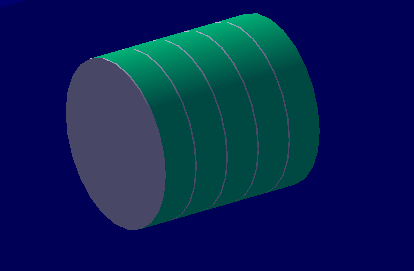
Where the gray is the lead and the green is the argon.


This will be used as our hadronic detector, and we shall include an electromagnetic detector beforehand, which will be a large body of liquid argon that aborbs a significant amount of the low energy/EM particles.

This was done by adding a large cylinder of argon to the front, and outputting the energy absorbed within the argon. We have also removed one of the lead-argon layers. This was all done within ```DetectorConstruction.cpp```, treating the EM calorimeter as an extra 'layer' of energy sensitive liquid argon, with a larger volume (defined in the cpp file at the top). Here is the code for the specific EM calorimeter
 


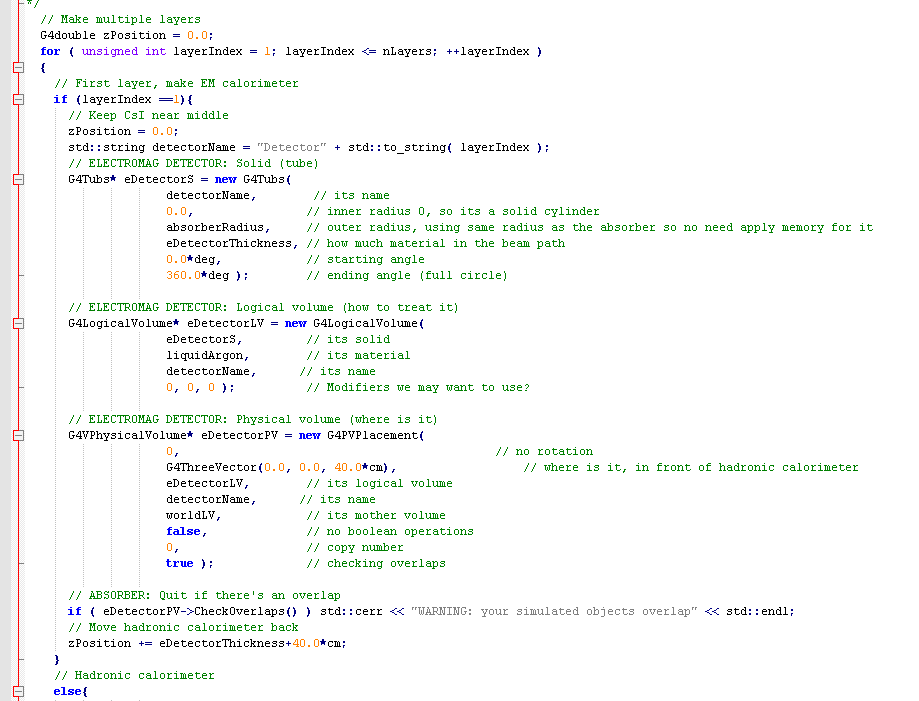

The else statement here creates the other thin argon/lead based calorimeter layers, which is the same as shown in checkpoint 9.

It is then treated like any other liquid argon layer in the detector, and so will the energy deposited will be printed to a csv file (output_nt_Energy)

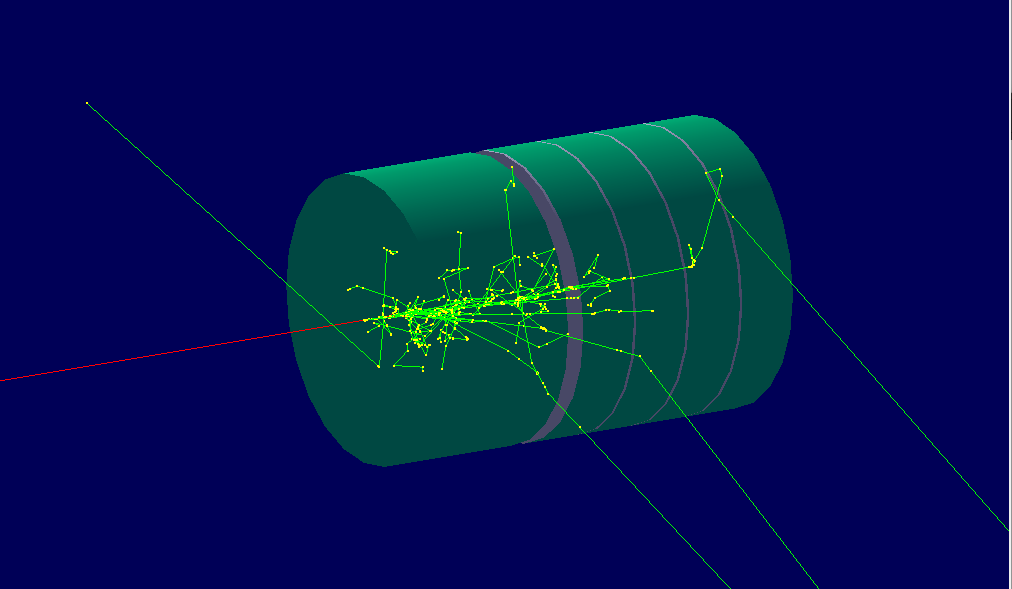

Next I moved the Liquid argon electromagnetic calorimeter back to leave no gap between it and the hadronic calorimeter, and added silicon wafers to take positional data. Then a magnetic field will be applied (in ```run.mac```) that allows us to know the charge of the incoming particles. Here is the creation of the silicon wafer within ```DetectorConstruction.cpp```

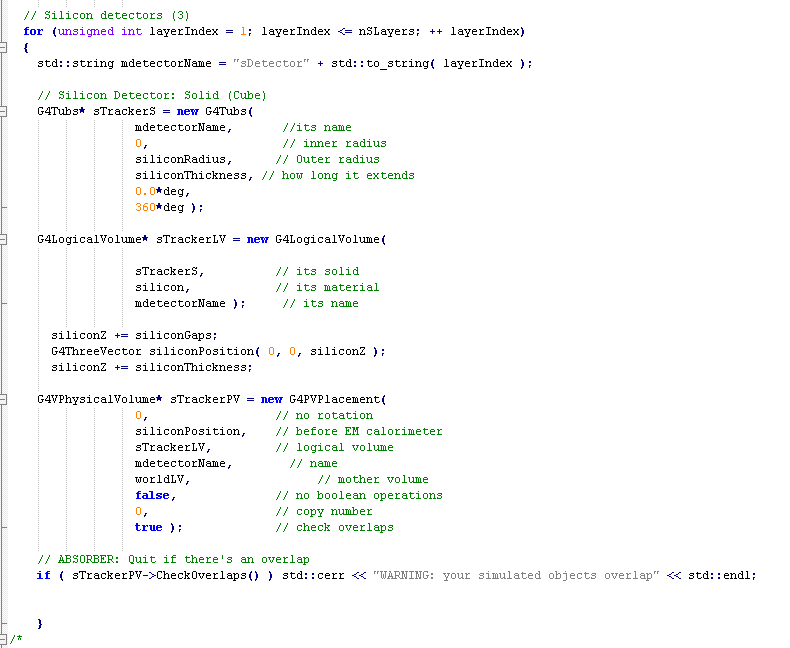
Again, the predefined values for thickness, gaps between them, are all defined at the top of ```DetectorConstruction.cpp```

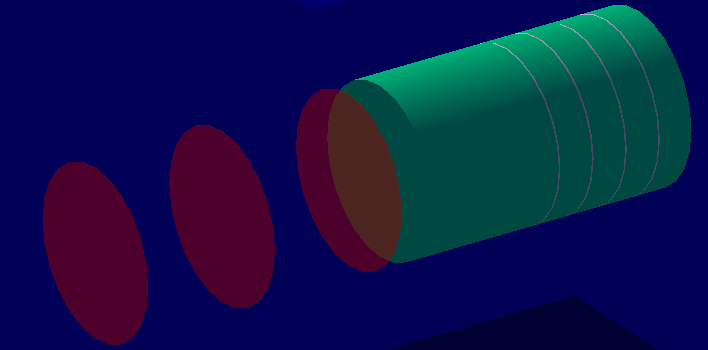

So we have the tracking component (silicon wafers), then the electromag calorimeter (big liquid argon section), followed by the hadronic calorimeter (lead + argon).

We can now print out the position of charged particles that come into contact with the silicon wafers, the particle type, as well as the deposited energy. Using this allows us to determine the charge of our particle and its estimate momentum. This was done by adding an entirely new .cpp file ```PositionFinder.cpp``` and setting up the Geant4 simulation to allow for printing of the positions when in contact with a particle (including it as a sensitive detector, producing new tuple files for each detector). Here is the code within ```DetectorConstruction.cpp``` that connects the silicon detector objects to the ```PositionFinder.cpp``` code:


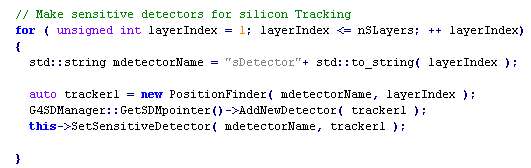

And the ```PositionFinder.cpp``` collects this data and saves the positional data, interacting particle, and energy absorbed to 3 ntuple files, one for each detector. The tuples that it saves to are created in ```RunAction.cpp```. Naturally, this file also contains a header that was created (```PositionFinder.h```), but these files are based on checkpoint 12's silicon tracking detectors, so there is no real difference here.

```PositionFinder.cpp```:
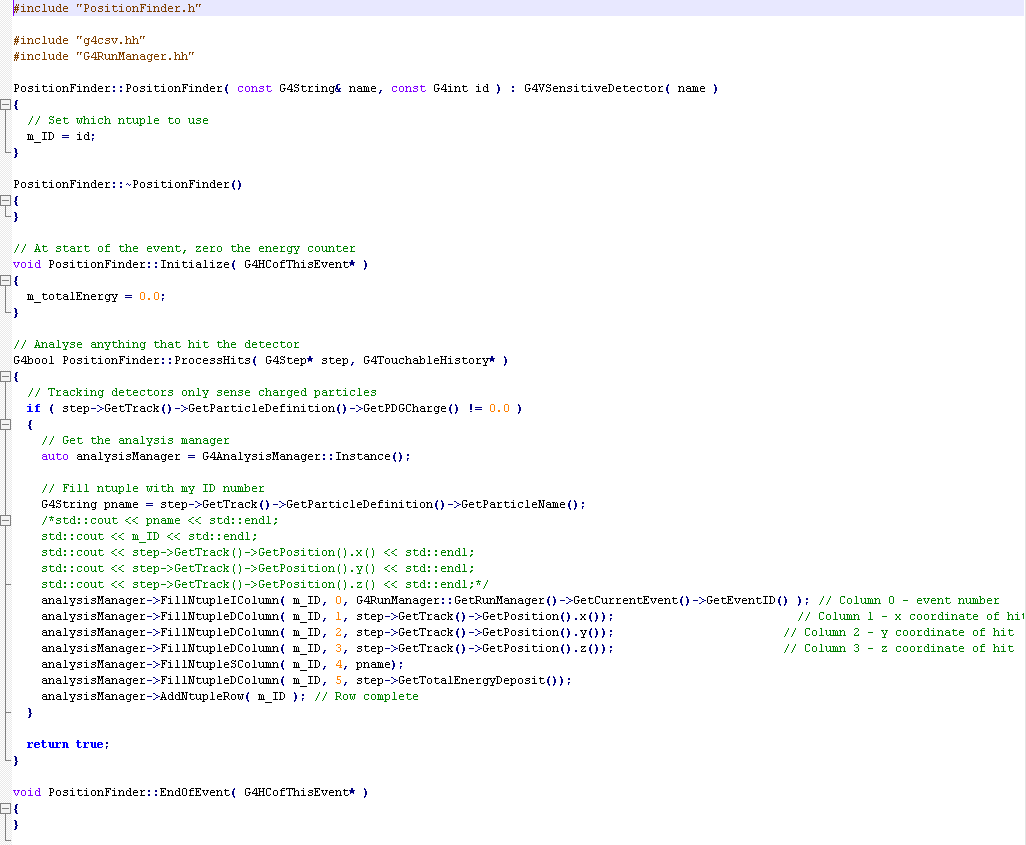
The tuples creation in ```RunAction.cpp```
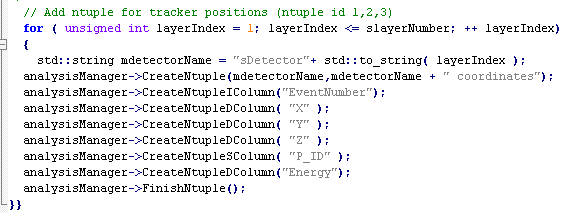

Silicon wafers are 80.2cm apart, and have been made smaller (20.0cm in radius), to try and avoid bounceback of particles

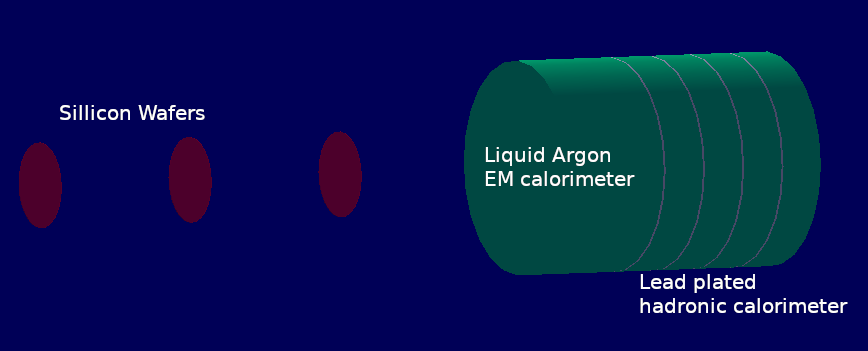
The finished detector, and an example of a proton being shot at 2000 MeV


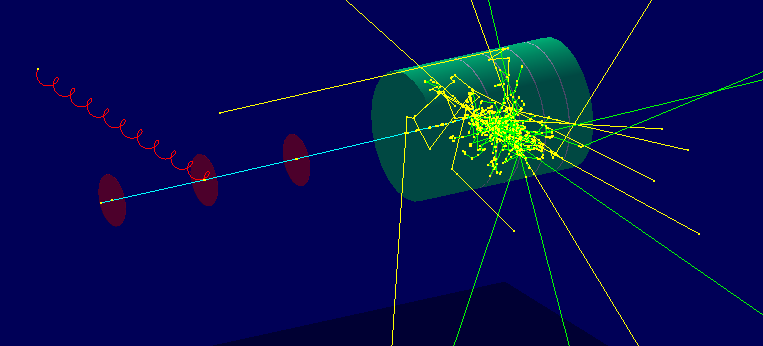

The silicon wafers were designed such that even for the lightest particle in consideration (electrons) the magnetic field isn't strong enough to completely push them off the wafers before hitting the calorimeter. **(T = 0.065 in X, so electrons move in -Y, positrons in +Y)**. So everything will be detected when passing through, but the silicon wafers are set up only to detect charged particles positions and energies, which works for our interests in this project. 

An issue I've found is that for electrons, photons are produced on the first silicon detector and pass straight through the rest, emitting energy into the calorimeter. This isnt an issue when we're trying to determine the energy of the particle, but it produces an extra input in the first silicon detector (as the electron decays into electron + photon, which it counts as two 'detections'). While this is annoying, we can acknowledge its existent in our data analysis and continue as normal.

## PART II - Data Reconstruction

From this, we will be able to determine the charge and an estimate of the momenta for our particles based on their positions on the silicon wafers, and then the energy from that deposited within the two calorimeters. We can try to determine the original energy and momenta of the particle with these results, and discern between different charged particles based on their path through the silicon tracker.

The particles we'll be considering in this project are electrons, protons and positrons across a range of energy values (200MeV -> 20 GeV). This should allow us to build up an image of how effective our detector is at discerning between these particles based on energy/momenta/charge.

Two separate datasets were collected, we will discuss the first dataset here, and analyse it.

Protons and electrons were shot 100 times at the detector, with increases in energy of 200MeV each time (200MeV->20000MeV), the silicon detectors have separate csv files for each detector (labelled 'output_nt_sDetector1/2/3'), with each gunshot being labelled as an 'ID', and the possibility of multiple products. The energy output in the hadronic and EM calorimeter are both output to the same file and saved based on the energy input (labelled 'output_nt_Energy'). So a 200MeV beam is event0, 400MeV beam is event1, etc. This is done by updating gun energy in ```GeneratorAction.cpp``` per each new event and shooting the gun 100 times upon running the code in ```run.mac```. Vis manager has also been removed in ```main.cpp``` to stop visualisation and increase the efficiency of data collection, as is shown in checkpoint 9:

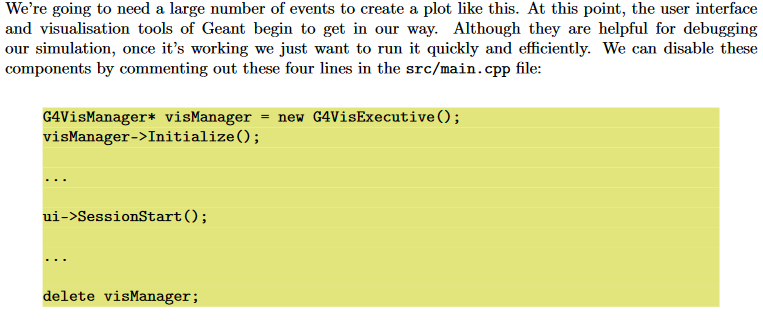

To look at the model, turn off the automated firing of the particle gun in ```run.mac``` and uncomment these lines in ```main.cpp```

These data files were collected to allow for reconstruction of the individual particles. We'll now load in the electronBeam particle data for manipulating and to create a method for identification:

In [ ]:
# Load in electron beam hits from detector 1,2,3
e_sDetector1 = pd.read_csv( "electronBeam/output_nt_sDetector1.csv", comment="#", \
names=[ "EventID", "X", "Y", "Z", "Particle", "Energy" ] )

e_sDetector2 = pd.read_csv( "electronBeam/output_nt_sDetector2.csv", comment="#", \
names=[ "EventID", "X", "Y", "Z", "Particle", "Energy" ] )

e_sDetector3 = pd.read_csv( "electronBeam/output_nt_sDetector3.csv", comment="#", \
names=[ "EventID", "X", "Y", "Z", "Particle", "Energy" ] )

# Load in energy data
e_energy = pd.read_csv( "electronBeam/output_nt_Energy.csv", comment="#", \
names=[ "Generated", "Layer1", "Layer2", "Layer3", "Layer4", "Layer5", "Layer6" ] )


# silicon detector 1
e_sDetector1

In [ ]:
# silicon detector 2
e_sDetector2

In [ ]:
# silicon detector 3
e_sDetector3

In [ ]:
# Deposited energy with total energy (Generated)
e_energy

The tables (excluding the energy) all have a different number of rows, this is due to the electrons producing photons or other particles while passing through the silicon detectors, therefore being recognised as a 'separate' particle. It can also be due to backscattering or other decay processes.

The easiest way to eliminate this issue is to use the first detected particle as the 'main particle', as it records each particle within the silicon detectors chronologically. This could have issues with particle decays producing 'useless' tracks through the detector, but in general this works well enough.

In [ ]:
# Collect only detections from detector 1 for event 50 as a demonstration
e_50 = e_sDetector1.loc[e_sDetector1['EventID'] == 50]
e_50

Here, Z only tells us the depth of the detector, or how far into the detector it is, X and Y are the relevant coordinates, and moreso Y than X. While X shouldn't change, Y will be expected to change between detectors due to the magnetic field. So in a case like this we'll take the sum of the deposited energy, and take the first particle detected's position for the Y and X values, and use that when determining the momentum and charge of the particle. 

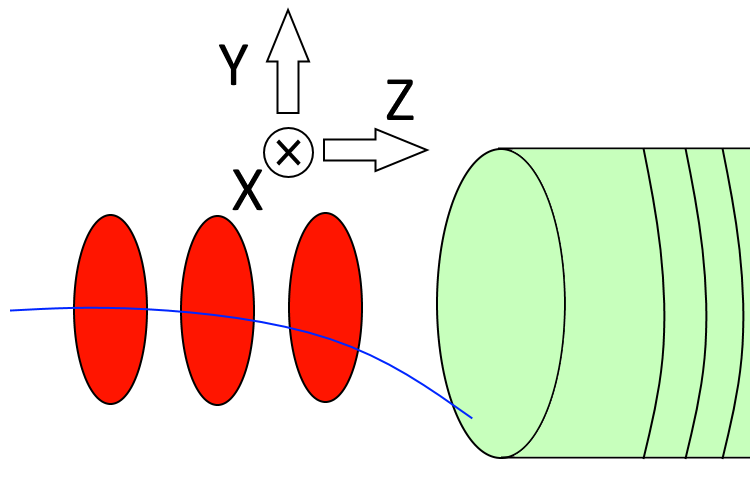


Plot showing our basic detector outline, with the XYZ coordinates shown, and a path of an electron in blue. The data from this detector can be very messy (as shown in the earlier proton gunshot), there are a lot of electron/proton decays and reactions with the detector, making it hard to parse the data. 

When this is caused by backscattering, it is obvious due to the XY position being completely different when compared to the initial XY position. For each event/gunshot we will take the first detected particles XY coordinates and use these XY coordinates for our momenta calculation. We will also want to include the energy deposited in the silicon detector when calculating the total deposited energy (although its minute), so we will collect the sum of the energy deposited and add that as a new row:

In [ ]:
# Convert energies and find the sum of total energies across event 50
q = sum(list(e_50['Energy']))

# Drop the later reactions
e_50 = e_50.drop_duplicates(subset='EventID', keep='first')

e_50

In [ ]:
# Insert total energy
e_50.insert(6, "Total Energy", [q])
e_50

Now we do the same for silicon detector 2 and 3 

In [ ]:
# Now collect detector2 and detector 3
e2_50 = e_sDetector2.loc[e_sDetector2['EventID'] == 50]
e2_50

In [ ]:
e3_50 = e_sDetector3.loc[e_sDetector3['EventID'] == 50]
e3_50

Luckily for us, after the first silicon detector, the particles pass through the silicon normally! Now we can take the energy input into the liquid argon/lead calorimeter, as we know its the 10200 MeV event

In [ ]:
# 50th event
ee_50 = e_energy.loc[e_energy['Generated'] == 10200]
ee_50

In [ ]:
# Take the sum of the energy deposited
ee_50_e = (ee_50.iloc[: , 1:]).sum(axis=1)

# Showing the Energy from second silicon detector
print(list(e2_50["Energy"]))

# Sum
print("Sum of energy deposited MeV")
print(ee_50_e + list(e2_50["Energy"])[0] + list(e3_50["Energy"])[0]+ list(e_50["Energy"])[0])


As we can see from the 'Generated' column, only half the energy is deposited into our detector! (6658.78 MeV of 10200 MeV) That's a little bit concerning, but this could be due to a lot of the energy being scattered away or not escaping out the detector. We'll now check the momentum of the particle passing through the silicon detectors using the same method from the previous checkpoint:

Our tracker planes are evenly spaced at 80.2cm apart, and we can determine the momenta via the Lorentz Force and some basic trig: 

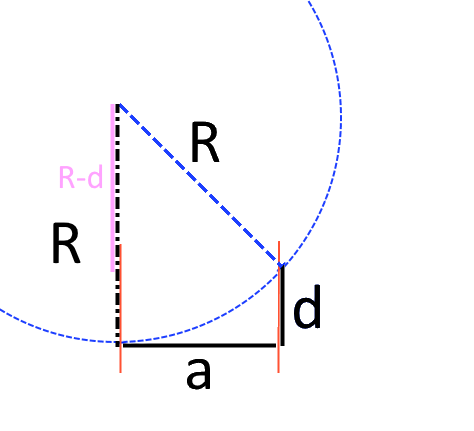

Here the blue line between the red bars is our particle track, affected by the magnetic field. The red lines signify our silicon detectors. We can use the equation for momenta $P = 0.3 B(T) R(m)$, and calculate R by using trig on the above setup. $R^2 = a^2 + (R-d)^2 \rightarrow R = \frac{a^2+d^2}{2d}$, where is a the spacing between the detectors (80.2cm -> 0.802m) and d is the Y coordinate on silicon detector (2/3) minus Y coordinate (1/2). Using this, we can get two approximations for the momenta based on the detector positions, and use that to determine the particle momenta.


In [ ]:
# Y coordinates of the two first detectors, convert to meters (in mm by default)
d1 = e_50.iloc[0]["Y"] * 10**-3
d2 = e2_50.iloc[0]["Y"] * 10**-3
print(d1)
print(d2)


In [ ]:
# Estimate momenta
a = 0.802 # metres
d = d2 - d1
print(d)

# Find R
numer = a**2 + d**2
#print(numer)

R = numer/(2*d)
print("R = {:.4f}m".format(abs(R)))

# Calculate P from this, B = 0.065 T
P = 0.3 * abs(R) * 0.065
print("P = {:.4f} GeV/c".format(P))

Momentum result is 9.8826 GeV/c for this specific section of the detector, which isnt too far from our expected 10.2 GeV energy input.

#### Note, this section was from when I was getting results wrong by a factor of 10, this is due to me thinking geant saved position data in cm, rather than mm. This has been resolved in the results, but I feel the analysis and problem solving is useful to leave here.
*Strange...its a factor of 10 smaller than we expect. Is this possibly because the silicon tracker has a significant portion of the energy deposited as non-charged particles? For example, we can see in this image of an electron track that a photon is deposited and just sent straight through the detector (200MeV e- beam):*

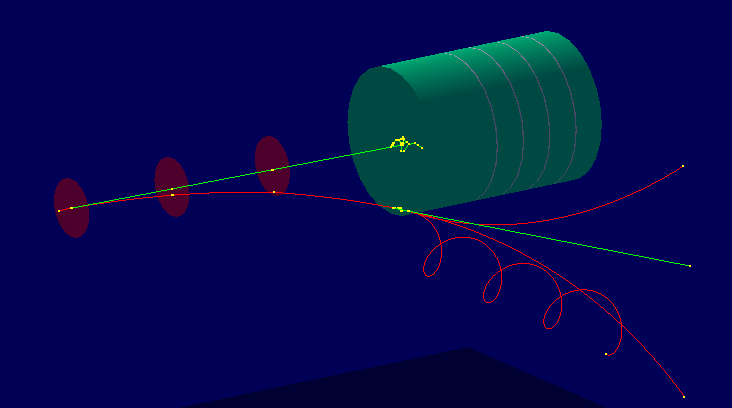 

Lets take the momenta between detector 2 and 3 also:

In [ ]:
# Y coordinates of the last detector, convert to meters (in mm by default)
d3 = e3_50.iloc[0]["Y"] * 10**-3
print(d3)

a = 0.802 # metres
d = d3 - d2


# Find R
numer = a**2 + d**2
#print(numer)

R = numer/(2*d)
print("R = {:.4f}m".format(abs(R)))

# Calculate P from this, B = 0.065 T
P = 0.3 * abs(R) * 0.065
print("P = {:.4f} GeV/c".format(P))

Surprisingly bad, might be something to do with the calculation method, but could also just be an outlier.

In [ ]:
a = 0.802*2 # metres but twice the length
d = d3 - d1
print(d)

# Find R
numer = a**2 + d**2
#print(numer)

R = numer/(2*d)
print("R = {:.4f}m".format(abs(R)))

# Calculate P from this, B = 0.065 T
P = 0.3 * abs(R) * 0.065
print("P = {:.4f} GeV/c".format(P))

Once again pretty close to the expected 10.2GeV/c. Lets try a different run, with lower energy, lets say 600 MeV (event 2):

In [ ]:
# Collect only this set of events from detector1,2 and 3, from event 2
e1_2 = e_sDetector1.loc[e_sDetector1['EventID'] == 2]
e2_2 = e_sDetector2.loc[e_sDetector2['EventID'] == 2]
e3_2 = e_sDetector3.loc[e_sDetector3['EventID'] == 2]

# print the detections from these 3 for 600 MeV
print(e1_2)
print(e2_2)
print(e3_2)



In [ ]:
# create a function that compiles total energy per each silicon wafer
def energy_compiler(dataframe):
    
    # Convert energies and find the sum
    q = sum(list(dataframe['Energy']))

    # Drop the later reactions
    dataframe = dataframe.drop_duplicates(subset='EventID', keep='first')

    # Insert total energy
    dataframe.insert(6, "Total Energy", [q])
    return dataframe

# compile the energies
e1_2 = energy_compiler(e1_2)
e2_2 = energy_compiler(e2_2)
e3_2 = energy_compiler(e3_2)

print(e1_2)
print(e2_2)
print(e3_2)

Seeing some curvature in the x axis, which is peculiar, as it shouldnt show any curvature in that direction...it seems consistent throughout the entirety of the data files, how odd. Lets collect total energy deposited in the calorimeter:

In [ ]:
# 2nd event
ee_2 = e_energy.iloc[[2]]

# Take the sum of the energy deposited (ignoring generated)
ee_2_e = (ee_2.iloc[: , 1:]).sum(axis=1)
print("Calorimeter deposited energy (MeV)")
print(ee_2_e)

# Sum of energy deposited in detector for 600 MeV
print("Total deposited energy")
print(ee_2_e + list(e1_2["Total Energy"])[0] + list(e2_2["Total Energy"])[0] + list(e3_2["Total Energy"])[0])

So again, losing approximately 22% of the energy...why? Lets check momentum now

In [ ]:
# Y coordinates of the 3 detectors, convert to meters (in mm by default)
d1 = e1_2.iloc[0]["Y"] * 10**(-3)
d2 = e2_2.iloc[0]["Y"] * 10**(-3)
d3 = e3_2.iloc[0]["Y"] * 10**(-3)

a = 0.802 # metres
d = d2 - d1
#print(d)

# Find R
numer = a**2 + d**2
#print(numer)
print(" d1 -> d2")

R = numer/(2*d)
print("R = {:.4f}m".format(abs(R)))

# Calculate P from this, B = 0.065 T
P1 = 0.3 * abs(R) * 0.065
print("P = {:.4f} GeV/c".format(P1))

print("d2 -> d3")

d = d3 - d2

numer = a**2 + d**2
R = numer/(2*d)
print("R = {:.4f}m".format(abs(R)))

# Calculate P from this, B = 0.065 T
P2 = 0.3 * abs(R) * 0.065
print("P = {:.4f} GeV/c".format(P2))

print("")
print("d1 -> d3")
a = 0.802*2
d = d3 - d1

numer = a**2 + d**2
R = numer/(2*d)
print("R = {:.4f}m".format(abs(R)))

# Calculate P from this, B = 0.065 T
P3 = 0.3 * abs(R) * 0.065
print("P = {:.4f} GeV/c".format(P3))


Again, d2->d3 is bad, might be something to do with the way I'm recording that information? I believe using d1 -> d2 and d1 -> d3 and taking one of these would provide better results if we cant rely on energy. We can also determine the charge of the particle based on its path, so the value d3 - d1 tells us the charge (-ve is -ve charge, +ve is +ve charge).

In [ ]:
# charge check
if (d < 0):
    print("-")
    Q = "-"
else:
    print("+")
    Q = "+"

So now we can collect all this information into separate datasheets

In [ ]:
# FORMAT DATA
# True Energy
# True Particle Type
# Deposited Energy
# Estimated momentum 1
# Estimated momentum 2
# Charge

# Take total E
Total_E = ee_2_e + list(e1_2["Total Energy"])[0] + list(e2_2["Total Energy"])[0] + list(e2_2["Total Energy"])[0]

# Create sample dataframe
data_e = {'True Energy (MeV)': [ee_2.iat[0,0]], 'True Particle': [e1_2.iat[0,4]], 'Depo_E (MeV)': [float(Total_E)], 'mom_est 1 (MeV)': [P1*1000], 'mom_est 2 (MeV)': [P3*1000], 'charge': [Q]}
sample_df = pd.DataFrame(data_e)
sample_df

So now I just need to make a function that takes in the dataframes and organises them like above. First we'll functionalise a few things so that the code looks less ugly.

In [ ]:
# returns two estimate momenta values in MeV and charge
def mom_calc_Q(a, d1, d2, d3, B):
    # give a in metres, and d1, d2 and d3 in metres, B in Tesla
    # Takes the displacements within the silicon wafers and calculated the momenta
    
    
    # First estimate
    d = d2 - d1
    # Find R
    numer = a**2 + d**2
    R = numer/(2*d)
    
    # Find first momenta
    P1 = (0.3 * abs(R) * B) * 1000 # MeV conversion x1000
    
    # Second Estimate, double the length
    a = a*2
    d = d3 - d1
    numer = a**2 + d**2
    R = numer/(2*d)
    
    P2 = (0.3 * abs(R) * B) * 1000 # MeV conversion x1000
    
    # find charge, if d -ve, charge is -ve and vice versa
    if (d < 0):
        Q = "-"
    elif (d > 0):
        Q = "+"
    else:
        Q = "0"
        
    
    return (P1, P2, Q)

# test
A1, A2, Q = mom_calc_Q(0.802, d1, d2, d3, 0.065)
print("{:.4f} MeV/c, {:.4f} MeV/c, {}".format(A1, A2, Q))
# Checks out

Now we create a basic function that calculates the momenta estimates, the charge classification and the total deposited energy for each event/gunshot, and spits out a new dataframe with all this data:

In [ ]:
# Dataframe organiser

# Will collect all info from one 'run' collection and produce a large dataframe with all the relevant info as shwon above

def sorting_hat(sDetector1, sDetector2, sDetector3, energy_df):
    
    # Initial Parameters
    a = 0.802 # metres, length between silicon wafers
    B = 0.065 # tesla, magnetic field in X dirn
    
    # Create initial dataframe
    rows_list = []
    #frame_dict = {'True Energy (MeV)': [], 'True Particle': [], 'Depo_E (MeV)': [], 'mom_est 1 (MeV)': [], 'mom_est 2 (MeV)': [], 'charge': []}
    #completed_frame = pd.DataFrame(frame_dict)
    
    # Will append modified and collated data to new frame via loop, passing over each entry
    # Length of loop defined by energy inputs
    for i in range(len(energy_df.index)):
        
        # Print to screen for long runs
        if (i%1000==0):
            print("{}/{}...".format(i,len(energy_df.index)))
        
        # Collect detections from silicon detectors relevant to this 'Event'
        es_1 = sDetector1.loc[sDetector1['EventID'] == i]
        es_2 = sDetector2.loc[sDetector2['EventID'] == i]
        es_3 = sDetector3.loc[sDetector3['EventID'] == i]
        
        # Convert energies and find the sum
        q1 = sum(list(es_1['Energy']))
        q2 = sum(list(es_2['Energy']))
        q3 = sum(list(es_3['Energy']))
        
        # Then squash array to give first positions and the total absorbed energies
        # Drop the later reactions
        es_1 = energy_compiler(es_1)
        es_2 = energy_compiler(es_2)
        es_3 = energy_compiler(es_3)
        
        #es_1 = es_1.drop_duplicates(subset='EventID', keep='first')
        #es_1.insert(6, "Total Energy", [q1])
        
        #es_2 = es_2.drop_duplicates(subset='EventID', keep='first')
        #es_2.insert(6, "Total Energy", [q2])
        
        #es_3 = es_3.drop_duplicates(subset='EventID', keep='first')
        #es_3.insert(6, "Total Energy", [q3])
        
        # Collect ith event from the energies then take total absorbed energy from each layer
        energy_specific = energy_df.iloc[[i]]
        abs_energy = (energy_specific.iloc[: , 1:]).sum(axis=1)
        
        # Calculate total absorbed energy
        total_abs_energy = abs_energy + list(es_1["Total Energy"])[0] + list(es_2["Total Energy"])[0] + list(es_3["Total Energy"])[0]
        
        # Collect the Y values of the 3 detectors, convert to metres
        d1 = es_1.iloc[0]["Y"] * 10**(-3)
        d2 = es_2.iloc[0]["Y"] * 10**(-3)
        d3 = es_3.iloc[0]["Y"] * 10**(-3)
        
        # Calculate momentum and charge
        mom1, mom2, Q = mom_calc_Q(a, d1, d2, d3, B)
        
        
        # Collect data in dictionary to create table later
        frame_dict = {'True Energy (MeV)': energy_specific.iat[0,0], 'True Particle': es_1.iat[0,4], 'Depo_E (MeV)': float(total_abs_energy), 'mom_est 1 (MeV)': mom1, 'mom_est 2 (MeV)': mom2, 'charge': Q}
        rows_list.append(frame_dict)
    
    # create dataframe out of rows and return it
    df = pd.DataFrame(rows_list)
    
    return df

In [ ]:
# Testing the sorting function above for our dataset

nice_frame = sorting_hat(e_sDetector1, e_sDetector2, e_sDetector3, e_energy)

nice_frame

Check quickly that charge is always correct:

In [ ]:
# Expect all charge to be negative (electrons)
nice_frame["charge"].value_counts()

All correct, good to see! This allows us to determine what particle we're seeing easily when comparing protons to electrons, as they will travel in opposite Y directions, and so give explicit charge values out (as shown above). This also allows us to get a measurement of the deposited energy in our detector and an estimate on the momenta of the particles through our detector (**these are the required components for part II**). So we can now measure the energy and momentum of particles over a range of two orders of magnitude, and can distinguish between different charged particles.

We can also use the penetration (or energy deposited) into the liquid argon detector to help determine the particle we expect to see. Generally it is understood that electrons will have smaller showers within our detector when compared to the hadronic shower of our protons, similar to what can be seen here: 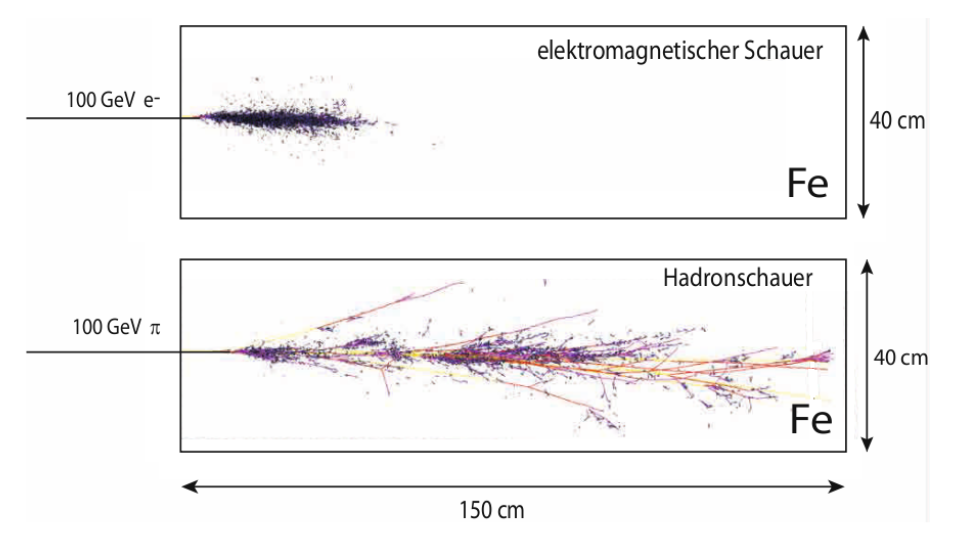




This is pions and electrons shot into iron. So we expect protons to create messier and longer trails within our detector, which should be reflected by larger deposits in the 'later' layers of our detector when compared to electrons, which should decay much quicker in our detector. While this isn't necessary for our electron-proton comparison, this could be an important consideration when we come to comparing protons to positrons, as the major difference will be the energy deposits.

Before we move onto Data validation, we will load in data files that contain 10000 gunshots from positrons and protons at 2000 MeV to demonstrate this point on layers being significant. These files will later be used to determine the resolution of our energy and momenta measurements at differing energies/ for differing particles, and then will be used to machine learning methods to improve our 'classification'.

In [ ]:
# Create function to read in from specific folders the relevant data

def data_reader(directory):
    # silicon detectors
    pr_sDetector1 = pd.read_csv( str(directory) + "output_nt_sDetector1.csv", comment="#", \
                                names=[ "EventID", "X", "Y", "Z", "Particle", "Energy" ] ) 


    pr_sDetector2 = pd.read_csv( str(directory) + "output_nt_sDetector2.csv", comment="#", \
                                names=[ "EventID", "X", "Y", "Z", "Particle", "Energy" ] ) 


    pr_sDetector3 = pd.read_csv( str(directory) + "output_nt_sDetector3.csv", comment="#", \
                                names=[ "EventID", "X", "Y", "Z", "Particle", "Energy" ] ) 

    # Load in energy data
    e_energy = pd.read_csv( str(directory) + "output_nt_Energy.csv", comment="#", \
    names=[ "Generated", "Layer1", "Layer2", "Layer3", "Layer4", "Layer5", "Layer6" ] )
    
    return pr_sDetector1, pr_sDetector2, pr_sDetector3, e_energy

In [ ]:
# load in positron and proton data at 200MeV
pos_s1, pos_s2, pos_s3, pos_e = data_reader("10000Events/positron/2000MeV/")
prot_s1, prot_s2, prot_s3, prot_e = data_reader("10000Events/proton/2000MeV/")


# Check
print(pos_s1.head(10))
print(prot_s1.head(10))

Now lets look at how the energy is deposited in the different energy layers, as sum of the total energy deposited in each layer for protons and positrons:

In [ ]:
# Collect prot_e and pos_e sums across layers
layer_list = ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Layer 5']

# [1:-1] to remove first and last components (generated number and layer 6 (which doesnt exist))
pos_layers = list(pos_e.sum())[1:-1]
prot_layers = list(prot_e.sum())[1:-1]

# Average across layers
pos_layera = list(pos_e.mean())[1:-1]
prot_layera = list(prot_e.mean())[1:-1]

In [ ]:
# plot bar charts

# Total
plt.figure(figsize=(10,10))
plt.bar(layer_list, pos_layers, label="Positrons")
plt.bar(layer_list, prot_layers, width = 0.5, label = "Protons")
plt.title("Total Energy deposited in each layer", fontsize = 14)
plt.ylabel("Energy (MeV)", fontsize = 12)
plt.legend(prop={'size':20})
plt.show()


# Average
plt.figure(figsize=(10,10))
plt.bar(layer_list, pos_layera, label="Positrons")
plt.bar(layer_list, prot_layera, width = 0.5, label = "Protons")
plt.title("Average Energy deposited in each layer", fontsize = 14)
plt.ylabel("Energy (MeV)", fontsize = 12)
plt.legend(prop={'size':20})
plt.show()



Very similar plots, but it can be seen here that positrons deposit the majority of their energy in the first couple of layers, and while protons tend to do the same they have a longer tail across the layers, and so have higher energies deposited in later layers when compared to positrons. It can also be seen that generally the protons deposit significantly less energy into the calorimeter than the positrons. This is most likely due to most of the resultant particles escaping the detector for protons, but being fully absorbed in the liquid argon for the positrons. This could be useful in the machine learning component of this project, as it would allow for easier classification between the different components.

So in this section we've been able to distinguish between two different type of particles fired in the detector based on calculations of the charge, as well as producing momentum and energy measurements that can (as shown above) be useful for determining different particles of the *same* charge (as will be discussed in the improvement). Now we will look at Data validation, starting by looking at Electrons and Protons, and their results over a range of gun energies (200MeV -> 20GeV, with 200 MeV steps between shots).

## Part II/III: Data validation (with better particle classification based on charge)


## BEAM DATA: SCAN ACROSS 200 MeV -> 20 GeV
We're going to continue by looking at the electron beam first, we have already loaded this data into our notebook, so will use it here

### Electrons

Lets plot out the deposited energy against true energy, as well as momentum esimates, to see if we can get an inkling for how off our results are.

Lets start with deposited energy into our liquid argon calorimeter:

#### Deposited Energy

Can we reasonably determine the energy of the original gunshot from the deposited energy? Lets find out:

In [ ]:
# collect the lists of relevant info
true_E_list = list(nice_frame["True Energy (MeV)"])
Depo_E_list = list(nice_frame["Depo_E (MeV)"])
mom_1_list = list(nice_frame["mom_est 1 (MeV)"])
mom_2_list = list(nice_frame["mom_est 2 (MeV)"])

# Produce a linear relation graphing function
def plot_linrel(list1, list2, title, xlabel, ylabel):
    
    # take largest values in each list, and create linear line between these spots
    l_max = max(list1)
    l_min = min(list1)
    
    L_max = max(list2)
    L_min = min(list2)
    
    # plot line along x=y, make first list true energy
    x = np.linspace(l_min, l_max, 200)
    y = x
    # plot straight line
    plt.figure(figsize=(10,10))
    plt.plot(x,y)
    plt.title(title, fontsize = 15)
    plt.xlabel(xlabel, fontsize = 12)
    plt.ylabel(ylabel, fontsize = 12)
    plt.scatter(list1, list2)
    plt.show()

    
# Plot deposited energy against true energy
plot_linrel(true_E_list, Depo_E_list, "True against Deposited Energy (e-)", "True Energy (MeV)", "Deposited Energy(MeV)")

It's clear that as we get to higher and higher energies, less and less of our expected energy reaches the detector. We could add a manual correction for that into our results (some sort of multiplier). I would assume something along the lines of x1.5 or so. Lets try it.

In [ ]:
modified_Depo_E_list = [i*1.55 for i in Depo_E_list]
plot_linrel(true_E_list, modified_Depo_E_list, "True against Modified Deposited Energy (e-)", "True Energy (MeV)", "Deposited Energy(MeV)")


This is a much better fit! Interestingly, we can determine this factor more accurately to 'fine-tune' our detector, as we can presume this lack in accurate values at high E is due to "inefficiency" in our detector. 

In truth its because a lot of particles scatter out of the detector and fly away, never to be fully absorbed as can be seen in this image here of a high MeV gunshot 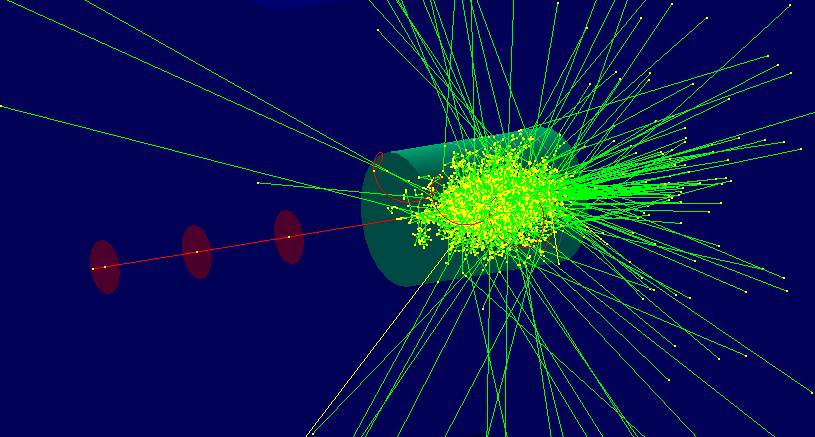

We can account for this quite nicely though. Lets try fitting a straight line to our normal deposited energy line:

In [ ]:
# define the straight line
def f(x, A, B):
    return A*x + B
popt, pcov = curve_fit(f, true_E_list, Depo_E_list)
print("Gradient: {:.4f}\nY intercept: {:.4f}\nErrors:".format(popt[0], popt[1]))
perr = np.sqrt(np.diag(pcov))
print(perr)
calibration_factor = popt[0]

So I'm getting a gradient here of 0.623(5), with a y intercept of 177(53). We want our gradient to be 1, so we can scale all of our data by 1/0.623. We could say that our efficiency of our detector is 62.3(5)% for electrons. While the fit on our gradient is quite good, our Y intercept has a large error and isn't too accurate.

In [ ]:
better_modified_Depo_E_list = [i*(1/popt[0]) for i in Depo_E_list]
plot_linrel(true_E_list, better_modified_Depo_E_list, "True against Modified Deposited Energy (e-)", "True Energy (MeV)", "Deposited Energy * (1/0.623) (MeV)")

This is a much better line of relation, and allows us to say quite adequately that we can determine the energy of our original beam across a range of two orders of magnitude for electrons. Lets determine the resolution of our momenta here:

In [ ]:
# difference between deposited and true
res = (np.array(better_modified_Depo_E_list) - np.array(true_E_list))/np.array(true_E_list)

# plot resolution as a histogram
plt.figure(figsize=(10,10))
plt.hist(res, bins = 50)
plt.xlabel("(Calibrated Energy - True Energy)/True Energy")
plt.ylabel("Counts")
plt.show()

# determine resolution and bias
print("Bias: {:.4f}\nResolution: {:.4f}".format(np.mean(res), np.std(res)))

While this resolution is pretty good, this resolution calculation would be better suited to a large list of gunshots with specific energies, but we can see that the resolution (ignoring an outlier) is pretty good.

There is also the issue of us having tuned our detector to allow for a better resolution by adjusting all our values for a fixed amount. We will keep this value that we offset our detector energy by across the rest of our particle datasets (for electrons at least).

We will come back to calculate the resolutions later for all the particles at set energies. Now we move onto the momentum of our particles compared to the true energy, as we make the decision that $E \approx P$ in our 'high energy' regime (for electrons, at least).

#### Calculated Momenta

Here we compare our calculated momenta to the initial energy. This works here due to the electrons being 'relativistic', so we can treat E $\approx$ P.

In [ ]:
# Plot the two momenta estimates
plot_linrel(true_E_list, mom_1_list, "True Energy against Estimate Momenta 1  (e-)", "True Energy (MeV)", "Momenta (MeV/c)")
plot_linrel(true_E_list, mom_2_list, "True Energy against Estimate Momenta 2  (e-)", "True Energy (MeV)", "Momenta (MeV/c)")

Momentum estimate 1 was across the first two silicon detectors, and estimate 2 was across the first and third detectors. This explains the decrease in variance of our momenta calculations from the first to the second. Even so, our variance is significant, and appears once again to have some bias for lower momenta. Lets fit another straight line to our second estimates results and apply it to our data:

In [ ]:
# Fit
popt, pcov = curve_fit(f, true_E_list, mom_2_list)
print("Gradient: {:.4f}\nY intercept: {:.4f}\nErrors:".format(popt[0], popt[1]))
perr = np.sqrt(np.diag(pcov))
print(perr)
# saving calibration factor for later
mom_e_calibration_factor = popt[0]

In [ ]:
# Modify
modified_mom_list = [i*(1/popt[0]) for i in mom_2_list]
plot_linrel(true_E_list, modified_mom_list, "True against Modified Momenta  (e-)", "True Energy (MeV)", "Modified Momenta (MeV/c)")

While the fit isn't terrible, its clear that the amount of scatter is large at high energy. This isn't too surprising, as the possibility of decays is significant at these higher energies. This is also shown in our gradient error of approximately 0.9039(350).


In [ ]:
# difference between deposited and true
res = (np.array(modified_mom_list) - np.array(true_E_list))/np.array(true_E_list)

# plot resolution as a histogram
plt.figure(figsize=(10,10))
plt.hist(res, bins = 50)
plt.xlabel("(Calibrated Momenta - True Momenta)/True Momenta")
plt.ylabel("Counts")
plt.show()

# determine mean resolution and std
print("Bias: {:.4f}\nResolution: {:.4f}".format(np.mean(res), np.std(res)))

Our resolution is quite large compared to the energy, but as we shall see throughout this project, a resolution of about 0.2 is quite common for our momenta calculation (which is a *pretty* rough approximation anyway).

Luckily for us, with the way we've designed our tracker, the ability to determine the charge of the input particle allows us to easily determine the difference between two charged particles (electrons and protons/positrons). Lets plot these results for protons to see if the increased mass has any significant impact on our results.

### Protons

Using the same dataset (200 MeV -> 20 GeV in 200 MeV steps)

In [ ]:
# Load in proton beam
p_sDetector1, p_sDetector2, p_sDetector3, p_energy = data_reader("protonBeam/")

In [ ]:
# Load in proton results
proton_frame = sorting_hat(p_sDetector1, p_sDetector2, p_sDetector3, p_energy)
proton_frame

Interestingly, I believe we may have some protons that travel so quickly through the detector that their charge is 0 rather than +, lets check this:

In [ ]:
proton_frame["charge"].value_counts()
#print("Number of 0 charge counts: {}".format())

Interesting, we get 3 values that show inaccurate results. Lets look at these results

In [ ]:
# Showing events that had negative charge
proton_frame.loc[proton_frame["charge"] == "-"]

In [ ]:
# Showing events that had 0 charge
proton_frame.loc[proton_frame["charge"] == "0"]

The negative events appear to show significantly smaller deposited energy when compared to the true energy. This may be due to a reaction with the first silicon detector that resulted in the outputs becoming significantly less energetic, and possibly negatively charged. We can check by looking at these event's silicon detector interactions:

In [ ]:
# Looking at the 46th event, compare it to tht 45th event (control)
print("EVENT 46")
display(p_sDetector1.loc[p_sDetector1['EventID'] == 46])
print("EVENT 45")
display(p_sDetector1.loc[p_sDetector1['EventID'] == 45])

Yep, dont need to say too much about why this event is incorrectly measured. Even oxygen 16 is created here! It's not too surprising that such a collision produces an inaccurate result when compared to the one just before it.

Our charge calculations are quite robust due to the very rudimentary system they use to be applied. This allows us to (most of the time) easily identify the different particles based on charge alone. It doesn't deal with edge cases like this well at all though, and must be considered when testing further.

It would be interesting to see if we could tell the difference between positrons and protons based on momentum results. This may be something to try as a stretch goal to further test our detector.

Lets continue to look at the deposited energy, and see if our standard correction factor will work here as well.

#### Deposited Energy

Lets create the graph:

In [ ]:
# collect the lists of relevant info
true_p_list = list(proton_frame["True Energy (MeV)"])
Depo_p_list = list(proton_frame["Depo_E (MeV)"])
mom_1p_list = list(proton_frame["mom_est 1 (MeV)"])
mom_2p_list = list(proton_frame["mom_est 2 (MeV)"])

# Plot deposited energy against true energy
plot_linrel(true_p_list, Depo_p_list, "True against Deposited Energy (P)", "True Energy (MeV)", "Deposited Energy(MeV)")

The deposited energy is really far off the mark. Possibly due to protons interacting more actively with the silicon? Lets try the calibration factor.

In [ ]:
mod_Depo_p_list = [i*(1/calibration_factor) for i in Depo_p_list]
plot_linrel(true_p_list, mod_Depo_p_list, "True against Deposited Energy (p)", "True Energy (MeV)", "Deposited Energy(MeV)")

It's clear here that our calibration factor isn't going to save us from incredibly messy results. This is almost definitely caused by the protons decaying before reaching the hadronic/EM calorimeter, or passing straight through it/decaying outwith it, as shown here: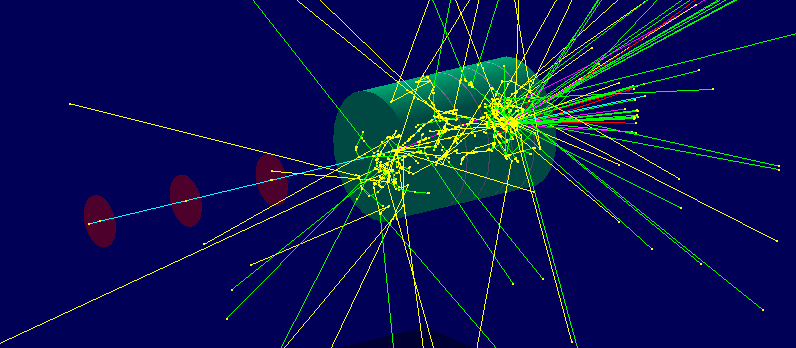 This is a 20000 MeV proton beam. Hopefully our momenta results are more fruitful.

#### Momenta

Lets give the momenta the same treatment. When considering protons we can no longer use the high energy assumption that E = P except for at energies above 6.6 GeV, so instead we'll be calculating the true momenta using the proton mass and the energy applied, and using that for our momenta esimates. Sadly this isn't too easy, as our range of energies is right in the sweet spot between relativistic and non-relativistic for protons (1% error in non-rel results when kinetic energy is greater than 9.38MeV, which it is.) So we will be calculating the relativistic momentum by finding the $\gamma$ factor from the kinetic energy:

In [ ]:
def proton_momenta(true_p_list):
    # calculate new list of proton momenta based on energy and mass
    
    proton_mass = 938.272088 #MeV
    # E = KE + m0c^2 (c=1)
    E_total_list = np.array(true_p_list) + proton_mass
    
    mom_list = np.sqrt(np.square(E_total_list) - proton_mass**2)
    
    
    return mom_list

For our proton momenta here, any values above 6.6 GeV (6600 MeV) we should use the true energy instead, but to avoid the discontinuity in this rough testing, we will just use the full 'calculated momenta' list.

In [ ]:
# calculate estimates of true momenta
true_momp_list = proton_momenta(true_p_list)

In [ ]:
# Plot the two momenta estimates
plot_linrel(true_momp_list, mom_1p_list, "True Energy against Estimate Momenta 1  (p)", "True Momenta (MeV/c)", "Momenta (MeV/c)")
plot_linrel(true_momp_list, mom_2p_list, "True Energy against Estimate Momenta 2  (p)", "True Momenta (MeV)", "Momenta (MeV/c)")

Theres quite a bit more variance, but it gives a better result than our deposited energy. We can expect the fall off near the higher energies to be due to the true momenta being lower than the values we calculate with our relativistic corrections (true energy at high MeV < true momenta as calculated above at high MeV). This will be accounted for when we choose specific energies in the next section of data validation.

Because one of our values has a 'nan' value, we have to account for this by setting nans to 0 for both x and y. 

In [ ]:
# The nan value, and its respective true value
print(mom_2p_list[59])
print(true_momp_list[59])

# remove the elements for fitting
clean_mom_list = [x for x in mom_2p_list if str(x) != 'nan']
clean_true_p_list = list(true_momp_list)[:59] + list(true_momp_list)[60:]

This nan result comes from the same run that didnt hit the hadronic/EM calorimeter or the 3rd silicon detector, so its not too surprising that this is the case. We shall remove this value from the fit.

In [ ]:
# Fiting
popt, pcov = curve_fit(f, clean_true_p_list, clean_mom_list)
print("Gradient: {:.4f}\nY intercept: {:.4f}\nErrors (m, intercept):".format(popt[0], popt[1]))
perr = np.sqrt(np.diag(pcov))
print(perr)
p_cal = popt[0]

plot_linrel(clean_true_p_list, clean_mom_list, "True Energy against Estimate Momenta 2  (p)", "True Momenta (MeV)", "Momenta (MeV/c)")

So there is still some inaccuracy in the fitting, about 6.6% on the gradient. This isn't as bad as expected, but again a factor could be applied to correct for this. This will be considered when we're determining the resolution. It's also odd that the Y intercept is such a large negative value, again is most likely due to the skew between momenta at high E being inaccurate due to our calculations.

Lets quickly determine the resolution of this system (again, we expect the values to be a bit dodgy due to the transition to relativistic energies midway through the data.)

In [ ]:
# get calibrated data based on gradient
cal_mom_list = [i*(1/p_cal) for i in clean_mom_list]


# difference between calculated and true momenta
res = (np.array(cal_mom_list) - np.array(clean_true_p_list))/np.array(clean_true_p_list)

# plot resolution as a histogram
plt.figure(figsize=(10,10))
plt.hist(res, bins = 50)
plt.xlabel("(Calibrated Momenta - True Momenta)/True Momenta")
plt.ylabel("Counts")
plt.show()

# determine mean resolution and std
print("Bias: {:.4f}\nResolution: {:.4f}".format(np.mean(res), np.std(res)))

Once again, the resolution is large (0.27). While this is a large resolution value, I believe this next data set (many events at specific energies) will produce better results.


## Validation and further resolution

So, our detector can accurately tell the difference between protons and electrons due to the charge differences between them. To get a efficiency value out for this, we will take 10000 gunshots at energies 200 MeV, 2000 MeV and 20000 MeV for both protons and electrons.

## 10000 EVENTS AT 200, 2000 AND 20000 MeV FOR PROTONS AND ELECTRONS

With this data, we can better determine the energy resolution of our detector at differing values. We can also determine the efficiency of our proton/electron classification system via charge. In a later component, we will use machine learning to also allow us to see if we can accurately classify particles correctly based on energy and momenta, and charge.

Lets load in these 200, 2000 and 20000 MeV datasets for protons and electrons and process them

### Electrons

#### WARNING this may take a while to run

In [ ]:
# Load in electron data and collect momenta and total energy in new tables
e200_detector1, e200_detector2, e200_detector3, e200_e = data_reader("10000Events/electron/200MeV/")
e2000_detector1, e2000_detector2, e2000_detector3, e2000_e = data_reader("10000Events/electron/2000MeV/")
e20000_detector1, e20000_detector2, e20000_detector3, e20000_e = data_reader("10000Events/electron/20000MeV/")

# Process data to get momentum and total deposited energy
print("200MeV...")
df_200e = sorting_hat(e200_detector1, e200_detector2, e200_detector3, e200_e)
print("2000MeV...")
df_2000e = sorting_hat(e2000_detector1, e2000_detector2, e2000_detector3, e2000_e)
print("20000MeV...")
df_20000e = sorting_hat(e20000_detector1, e20000_detector2, e20000_detector3, e20000_e)

In [ ]:
# Just to show what the new dataframe looks like
df_200e

Adding a little bit of code here to remove rows with nan values, as they mess up all of our results. We can consider these as 'rogue' variables. We will also see count the types of charges in each of our energy ranges, and use this to determine an efficiency (including rogue variables).

In [ ]:
# Drop nans
df_200e = df_200e.dropna()
df_2000e = df_2000e.dropna()
df_20000e = df_20000e.dropna()

# Check charges
print("200 MeV Electrons")
print(df_200e["charge"].value_counts())
print("2000 MeV Electrons")
print(df_2000e["charge"].value_counts())
print("20000 MeV Electrons")
print(df_20000e["charge"].value_counts())

##### Efficiency of Electron detection across 200, 2000 and 20000 MeV
So lets pull out an efficiency of classification of electrons for each energy band. This is efficiency for classifying between electrons and positrons *exclusively*. It has obvious flaws if applied to any other particles, due to its rudimentary nature, but it works well (and simply) here for showing how regularly we can determine the charge of our particles from the detector data, and consequently how well we can tell electrons and protons apart.

In [ ]:
# Takes original dataframe size, and dataframe excluding nans, and expected charge, then calculates efficiency
# and spits out nice zipped data as well
def efficiency(dataframe, df_LEN, Q):
    # INPUT CHARGE AS STRING OF "-" OR "+" based on particle type (proton, electron)
    
    
    # collect number of charge counts for each
    a = dataframe["charge"].value_counts()
    b = a.index.tolist()
    # zip them together
    c = list(zip(b,a))
    
    # Take the number of counts of relevant charge
    d = [item[1] for item in c if item[0] == Q][0]
    #print(d)
    # calculate efficiency
    # WARNING, this system will always assume that the largest 'count' 
    # charge will be the one we expect to be 'correct'. This is because our models are very good, but this would
    # need to be more rigorous for models with less than 50% efficiency.
    
    effic = d/df_LEN
    print("Particle identification efficiency: {:.2f}%".format(effic*100))
    
    return c, effic
    
print("200 MeV Electrons")
# find how many we accurately identify as negatively charged (aka electrons) from our data
data200, eff200 = efficiency(df_200e, 10000, "-")

print("")
print("2000 MeV Electrons")
data2000, eff2000 = efficiency(df_2000e, 10000, "-")

print("")
print("20000 MeV Electrons")
data20000, eff20000 = efficiency(df_20000e, 10000, "-")


So our electron identification is actually really good at high energy! This may be due to fewer electrons losing energy/decaying in the silicon detectors and never completing a full trajectory.

##### Resolution - 200 MeV

Now we'll determine the resolution of our energy and momenta values (again assuming in high energy regime P $\approx$ E)

When calibrating our results, we either use the correlation factor from the straight line fitting from before, or if they were inadequate, make new ones based on the calibration method shown in checkpoint 9 (average of E_true/E_detected and multiply all detected values by this to get calibrated energy).

In [ ]:
# create a function to find resolution automatically. Include calibration factor for deposited energy
def resolution_calc(dataframe, corr_fact_E = 0, corr_fact_P = 0, skip = 1):
    
    # Pull lists
    true_E_list = list(dataframe["True Energy (MeV)"])
    depo_E_list = list(dataframe["Depo_E (MeV)"])
    mom_est_list = list(dataframe["mom_est 2 (MeV)"])
    
    # Add skip to energy calibration
    if skip==1:
        # Add calibration factor
        if (corr_fact_E != 0):
            depo_E_list = [i*(corr_fact_E) for i in depo_E_list]
        else:
            # create own calibration constant if not provided
            corr_fact_E = np.mean(np.array(true_E_list)/np.array(depo_E_list))
            depo_E_list = [i*(corr_fact_E) for i in depo_E_list]
        
    if (corr_fact_P != 0):
        mom_est_list = [i*(corr_fact_P) for i in mom_est_list]
    else:
        # create own calibration constant if not provided
        corr_fact_P = np.mean(np.array(true_E_list)/np.array(mom_est_list))
        mom_est_list = [i*(corr_fact_P) for i in mom_est_list]
        
        
    # Determine resolution list
    resolution_list_mom = (np.array(mom_est_list) - np.array(true_E_list))/np.array(true_E_list)
    resolution_list_E = (np.array(depo_E_list) - np.array(true_E_list))/np.array(true_E_list)
    
    # Determine mean and std
    mean_res_mom = np.mean(resolution_list_mom)
    std_res_mom = np.std(resolution_list_mom)
    mean_res_E = np.mean(resolution_list_E)
    std_res_E = np.std(resolution_list_E)
    
    
    # return full list, mean resolution and standard deviation
    return resolution_list_mom, resolution_list_E, mean_res_mom, mean_res_E, std_res_mom, std_res_E

In [ ]:
# 200 MeV, including calibration factor here from earlier fitting

res_list_mom, res_list_E, mean_res_mom, mean_res_E, std_res_mom, std_res_E = resolution_calc(df_200e, 1/calibration_factor, 1/mom_e_calibration_factor)

# plot resolution as a histogram
plt.figure(figsize=(10,10))
plt.title("Energy Resolution, 200 MeV electron Beam", fontsize = 15)
plt.hist(res_list_E, bins = 50)
plt.xlabel("(Calibrated Energy - True Energy)/True Energy")
plt.ylabel("Counts")
plt.show()

print("200 MeV e- Beam\nEnergy Bias: {:.4f}\nEnergy Resolution: {:.6f}".format(mean_res_E, std_res_E))

# plot resolution as a histogram
plt.figure(figsize=(10,10))
plt.title("Momentum Resolution, 200 MeV electron Beam", fontsize = 15)
plt.hist(res_list_mom, bins = 500)
plt.xlabel("(Calibrated Momenta - True Momenta)/True Momenta")
plt.ylabel("Counts")
plt.show()

print("200 MeV e- Beam\nMomenta Bias: {:.4f}\nMomenta Resolution: {:.6f}".format(mean_res_mom, std_res_mom))


Here our energy resolution is large. This could be due to our calibrated energies still being too small when compared to our true energies, or the low energy beam creating a lot of variance in the deposited energies due to having difficult reaching the detector. This demonstrates the need for better calibration, but the method used in checkpoint 9 actually decreases the resolution significantly, so was dismissed.

Clearly theres a an unbelievably large rogue value in our momentum calculations. Lets identify it and remove it. *Note from the future, there are actually a BUNCH of inaccurate momenta values*

In [ ]:
# Identify and highlight rogue
print(np.where(res_list_mom == res_list_mom.min()))
print(res_list_mom[6266:6268])
#print(df_200e.loc[[6266:6268]])
print(df_200e[6266:6268])

So we can see here that this momentum is vastly exaggerated. Lets remove all values above a certain calculated momenta (as the particles are clearly being misidentified here).

In [ ]:
# new table of df_200e without massive momentum estimates
df_200e_clean = df_200e.drop(df_200e[df_200e["mom_est 2 (MeV)"] > 400].index)
# also remove any where first momentum calculation is really far off
df_200e_clean = df_200e_clean.drop(df_200e_clean[df_200e_clean["mom_est 1 (MeV)"] > 400].index)
print(df_200e_clean.max())

Appears that our momenta calculations aren't going to work as neatly as expected for such large datasets, with large outliers. I've added an upper limit on the momentum estimates, but I'm not too happy about having to do this, as it implies that our detector requires specific finetuning for each energy range, which is not what I'd like. Regardless, lets use this new data to create a momenta resolution, when confined for momenta results of 400 MeV.

In [ ]:
# find resolution again
res_list_mom, res_list_E, mean_res_mom, mean_res_E, std_res_mom, std_res_E = resolution_calc(df_200e_clean, 0, 1/mom_e_calibration_factor)
# plot resolution as a histogram
plt.figure(figsize=(10,10))
plt.title("Momentum Resolution, 200 MeV electron Beam", fontsize = 15)
plt.hist(res_list_mom, bins = 500)
plt.xlabel("(Calibrated Momenta - True Momenta)/True Momenta")
plt.ylabel("Counts")
plt.show()

print("200 MeV e- Beam\nMomenta Bias: {:.4f}\nMomenta Resolution: {:.6f}".format(mean_res_mom, std_res_mom))

We appear to have a relatively nice distribution, with a good resolution and a small bias.

So we have some bias towards the negative side, with a tail in the positives (this is where all the massive momenta values come from, for example). 

While it looks like we have cut the energy off on the left side, this isn't due to our limitation of the momentum estimates, as adjusting them doesn't remove this 'cutoff'. This is mostly likely caused by a lower limit on our calibrated momenta, which may be defined by having 0 MeV or something very close.

We'll go through the 2000 MeV and 20000 MeV results a bit quicker (in terms of code) just because its the same process:

#### Resolution - 2000 MeV

In [ ]:
# clean 2000 MeV data to remove massive rogues (above 4000 MeV momenta)
# new table of df_200e without massive momentum estimates
df_2000e_clean = df_2000e.drop(df_2000e[df_2000e["mom_est 2 (MeV)"] > 4000].index)
# also remove any where first momentum calculation is really far off
df_2000e_clean = df_2000e_clean.drop(df_2000e_clean[df_2000e_clean["mom_est 1 (MeV)"] > 4000].index)



# 2000 MeV, including calibration factor here for energy

# using older calibration factor method here for energy
res_list_mom, res_list_E, mean_res_mom, mean_res_E, std_res_mom, std_res_E = resolution_calc(df_2000e_clean, 0, 1/mom_e_calibration_factor)

# plot resolution as a histogram - ENERGY
plt.figure(figsize=(10,10))
plt.title("Energy Resolution, 2000 MeV electron Beam", fontsize = 15)
plt.hist(res_list_E, bins = 50)
plt.xlabel("(Calibrated Energy - True Energy)/True Energy")
plt.ylabel("Counts")
plt.show()


print("2000 MeV e- Beam\nEnergy Bias: {:.4f}\nEnergy Resolution: {:.6f}".format(mean_res_E, std_res_E))


# plot resolution as a histogram - MOMENTA
plt.figure(figsize=(10,10))
plt.title("Momentum Resolution, 2000 MeV electron Beam", fontsize = 15)
plt.hist(res_list_mom, bins = 500)
plt.xlabel("(Calibrated Momenta - True Momenta)/True Momenta")
plt.ylabel("Counts")
plt.show()

print("2000 MeV e- Beam\nMomenta Bias: {:.4f}\nMomenta Resolution: {:.6f}".format(mean_res_mom, std_res_mom))


These results are a lot more promising, most likely due to the reduction in variance from low energy electrons decaying before reaching the liquid argon detector. Our energy results have a very low resolution and bias, but our momenta still has a rather large resolution. This isn't too surprising, considering our method for determining the momenta.

The left side cutoff that was present in 200 MeV is not shown here, most likely due to the higher MeV allowing for smaller (and more inaccurate) values of momentum to be present.

For momenta, here we limited the values to 4000 MeV, and will limit to 40000 MeV in the next resolution calculation

#### Resolution - 20000 MeV

In [ ]:
# clean 2000 MeV data to remove massive rogues (above 4000 MeV momenta)
# new table of df_200e without massive momentum estimates
df_20000e_clean = df_20000e.drop(df_20000e[df_20000e["mom_est 2 (MeV)"] > 40000].index)
# also remove any where first momentum calculation is really far off
df_20000e_clean = df_20000e_clean.drop(df_20000e_clean[df_20000e_clean["mom_est 1 (MeV)"] > 40000].index)



# 2000 MeV, including calibration factor here for energy

# no calibration factor for energy here, remake anew as the original doesn't work as well here.
res_list_mom, res_list_E, mean_res_mom, mean_res_E, std_res_mom, std_res_E = resolution_calc(df_20000e_clean, 0, 1/mom_e_calibration_factor)

# plot resolution as a histogram - ENERGY
plt.figure(figsize=(10,10))
plt.title("Energy Resolution, 20000 MeV electron Beam", fontsize = 15)
plt.hist(res_list_E, bins = 50)
plt.xlabel("(Calibrated Energy - True Energy)/True Energy")
plt.ylabel("Counts")
plt.show()


print("20000 MeV e- Beam\nEnergy Bias: {:.4f}\nEnergy Resolution: {:.6f}".format(mean_res_E, std_res_E))


# plot resolution as a histogram - MOMENTA
plt.figure(figsize=(10,10))
plt.title("Momentum Resolution, 20000 MeV electron Beam", fontsize = 15)
plt.hist(res_list_mom, bins = 500)
plt.xlabel("(Calibrated Momenta - True Momenta)/True Momenta")
plt.ylabel("Counts")
plt.show()

print("20000 MeV e- Beam\nMomenta Bias: {:.4f}\nMomenta Resolution: {:.6f}".format(mean_res_mom, std_res_mom))


Here our energy resolution is even better, with a very small bias and resolution. This is most likely due to the higher energy electrons having no issue reaching the final detector and being absorbed. So its clear that with higher energy, our energy resolution improves for electrons

For momenta, again we have similar bias and resolution when compared to 2000 MeV, which suggests a possible 'lower baseline' for our momenta resolution of about 0.2 across a large energy range, or that our calibration method isn't good enough to represent the data as well as it should.

Now lets continue onto protons

### PROTONS

Lets load the files in:

In [ ]:
# Load in proton data and collect momenta and total energy in new tables
p200_detector1, p200_detector2, p200_detector3, p200_e = data_reader("10000Events/proton/200MeV/")
p2000_detector1, p2000_detector2, p2000_detector3, p2000_e = data_reader("10000Events/proton/2000MeV/")
p20000_detector1, p20000_detector2, p20000_detector3, p20000_e = data_reader("10000Events/proton/20000MeV/")

# Process data to get momentum and total deposited energy
print("200MeV...")
df_200p = sorting_hat(p200_detector1, p200_detector2, p200_detector3, p200_e)
print("2000MeV...")
df_2000p = sorting_hat(p2000_detector1, p2000_detector2, p2000_detector3, p2000_e)
print("20000MeV...")
df_20000p = sorting_hat(p20000_detector1, p20000_detector2, p20000_detector3, p20000_e)


##### Efficiency of Proton detection across 200, 2000 and 20000 MeV
Using previously made code, we can determine the proton identification efficiencies quite easily, but first we need to remove nan values. Just as a note, these nan values are counted in the efficiencies as incorrect measurements. So our high efficiencies are considering the fact that sometimes the detectors just don't pick the particles up correctly (if at all).

In [ ]:
# Drop nans
df_200p = df_200p.dropna()
df_2000p = df_2000p.dropna()
df_20000p = df_20000p.dropna()

In [ ]:
print("200 MeV Protons")
# find how many we accurately identify as positively charged (aka protons) from our data
p_data200, p_eff200 = efficiency(df_200p, 10000, "+")

print("")
print("2000 MeV Protons")
p_data2000, p_eff2000 = efficiency(df_2000p, 10000, "+")

print("")
print("20000 MeV Protons")
p_data20000, p_eff20000 = efficiency(df_20000p, 10000, "+")

So we can see here that our particle identification based on charge is very successful! We can identify protons across all energies with very high efficiency. Now lets look at the resolution of each:

#### Resolution - 200 MeV

For our 200 and 2000 MeV, we cant use true energy with respect to momenta so will have to calculate that separately to get a true momentum and consequently a correct resolution.

In [ ]:
# create a function to find resolution automatically. Include calibration factor for deposited energy
def resolution_calc_proton(dataframe, corr_fact_E = 0, corr_fact_P = 0, skip = 1):
    # resolution calculation function for when proton beam energy is too low to be considered relativistic
    # skip is a special ability to skip energy calibration, for use in 2000 MeV
    
    # Pull lists
    true_E_list = list(dataframe["True Energy (MeV)"])
    depo_E_list = list(dataframe["Depo_E (MeV)"])
    mom_est_list = list(dataframe["mom_est 2 (MeV)"])
    
    
    # Calculate momentum based on energy (assuming proton)
    true_mom_list = proton_momenta(true_E_list)
    #print(true_mom_list)
    
    
    # Added special skip ability, just for energy deposit plots later
    if (skip==1):
            # Add calibration factor     ##### COMMENT ME OUT IF YOU WANT TO SEE ENERGY RESOLUTION AT CENTRE
        if (corr_fact_E != 0):                                                                            #
            depo_E_list = [i*(corr_fact_E) for i in depo_E_list]                                          #
        else:                                                                                             #
            # create own calibration constant if not provided                                             #
            corr_fact_E = np.mean(np.array(true_E_list)/np.array(depo_E_list))                            #
            depo_E_list = [i*(corr_fact_E) for i in depo_E_list]                                          #
                                        ##### COMMENT ME OUT IF YOU WANT TO SEE ENERGY RESOLUTION AT CENTRE
    if (corr_fact_P != 0):
        mom_est_list = [i*(corr_fact_P) for i in mom_est_list]
    else:
        # create own calibration constant if not provided
        corr_fact_P = np.mean(np.array(true_mom_list)/np.array(mom_est_list))
        mom_est_list = [i*(corr_fact_P) for i in mom_est_list]
    
    # Determine resolution list
    resolution_list_mom = (np.array(mom_est_list) - np.array(true_mom_list))/np.array(true_mom_list)
    resolution_list_E = (np.array(depo_E_list) - np.array(true_E_list))/np.array(true_E_list)
    
    # Determine mean and std
    mean_res_mom = np.mean(resolution_list_mom)
    std_res_mom = np.std(resolution_list_mom)
    mean_res_E = np.mean(resolution_list_E)
    std_res_E = np.std(resolution_list_E)
    
    
    # return full list, mean resolution and standard deviation
    return resolution_list_mom, resolution_list_E, mean_res_mom, mean_res_E, std_res_mom, std_res_E

When clamping the momenta values here we need to remember that the momenta is going to be greater than the beam energy, so give more room in the upper end of momenta.

Remember that for the initial proton plots, the energies were so inconsistent that we couldnt get a nice fit and consequently a nice calibration factor. For the momenta however, we do have a nice calibration factor. So here we will use the calibration method from checkpoint 9 for energy (as mentioned above), and the factor from the straight line fitting for momenta.

In [ ]:
# clamp momentum values

df_200p_clean = df_200p.drop(df_200p[df_200p["mom_est 2 (MeV)"] > 1200].index)
# also remove any where first momentum calculation is really far off
df_200p_clean = df_200p_clean.drop(df_200p_clean[df_200p_clean["mom_est 1 (MeV)"] > 1200].index)




# 200 MeV, no calibration factor here

res_list_mom, res_list_E, mean_res_mom, mean_res_E, std_res_mom, std_res_E = resolution_calc_proton(df_200p_clean, 0, 1/p_cal)

# plot resolution as a histogram
plt.figure(figsize=(10,10))
plt.title("Energy Resolution, 200 MeV proton Beam", fontsize = 15)
plt.hist(res_list_E, bins = 50)
plt.xlabel("(Calibrated Energy - True Energy)/True Energy")
plt.ylabel("Counts")
plt.show()

print("200 MeV p Beam\nEnergy Bias: {:.4f}\nEnergy Resolution: {:.6f}".format(mean_res_E, std_res_E))

# plot resolution as a histogram
plt.figure(figsize=(10,10))
plt.title("Momentum Resolution, 200 MeV proton Beam", fontsize = 15)
plt.hist(res_list_mom, bins = 500)
plt.xlabel("(Calibrated Momenta - True Momenta)/True Momenta")
plt.ylabel("Counts")
plt.show()

print("200 MeV p Beam\nMomenta Bias: {:.4f}\nMomenta Resolution: {:.6f}".format(mean_res_mom, std_res_mom))


For energy here, we have a long tail in the resolution values, most likely caused by some of the energy not being absorbed within our liquid argon calorimeter. This artificially shifts the values right in our plot (hence the massive spike near 0.2) making the fit look worse than it actually is. If we remove the calibration factor (which can be done in the code above by commenting out the correlation factor part of 'resolution_calc_proton') this large peak will be shifted to zero. If we had a detector that did better at absorbing the total energy, we could reduce the large resolution here.

The momenta bias and resolution mirrors that shown by electrons, although the resolution is a little larger, at 0.25. Hopefully at higher energy beams, this stops being as large of an issue.

##### Resolution - 2000 MeV

In [ ]:
# clamp momentum values

df_2000p_clean = df_2000p.drop(df_2000p[df_2000p["mom_est 2 (MeV)"] > 12000].index)
# also remove any where first momentum calculation is really far off
df_2000p_clean = df_2000p_clean.drop(df_2000p_clean[df_2000p_clean["mom_est 1 (MeV)"] > 12000].index)




# 200 MeV, no calibration factor here

res_list_mom, res_list_E, mean_res_mom, mean_res_E, std_res_mom, std_res_E = resolution_calc_proton(df_2000p_clean, 0, 1/p_cal)

# plot resolution as a histogram
plt.figure(figsize=(10,10))
plt.title("Energy Resolution, 2000 MeV proton Beam", fontsize = 15)
plt.hist(res_list_E, bins = 50)
plt.xlabel("(Calibrated Energy - True Energy)/True Energy")
plt.ylabel("Counts")
plt.show()

print("2000 MeV p Beam\nEnergy Bias: {:.4f}\nEnergy Resolution: {:.6f}".format(mean_res_E, std_res_E))

# plot resolution as a histogram
plt.figure(figsize=(10,10))
plt.title("Momentum Resolution, 2000 MeV proton Beam", fontsize = 15)
plt.hist(res_list_mom, bins = 500)
plt.xlabel("(Calibrated Momenta - True Momenta)/True Momenta")
plt.ylabel("Counts")
plt.show()

print("2000 MeV p Beam\nMomenta Bias: {:.4f}\nMomenta Resolution: {:.6f}".format(mean_res_mom, std_res_mom))


Our momenta resolution and bias are as expected here and follow in line with previous resolution calculations. While its still a bit large, which is surely a limitation of our detector. This is most likely caused by rogues and could be reduced if the limits were also reduced. This will be done in the next step.

What is peculiar is the shape that comes out for energy, we see a gaussian distribution, with a strange peak at -0.5. Due to our calibration method, I'm sure these values are skewed, so lets run it again without the calibration:

In [ ]:
# clamp momentum values

df_2000p_clean = df_2000p.drop(df_2000p[df_2000p["mom_est 2 (MeV)"] > 4000].index)
# also remove any where first momentum calculation is really far off
df_2000p_clean = df_2000p_clean.drop(df_2000p_clean[df_2000p_clean["mom_est 1 (MeV)"] > 4000].index)




# 200 MeV, no calibration factor here

res_list_mom, res_list_E, mean_res_mom, mean_res_E, std_res_mom, std_res_E = resolution_calc_proton(df_2000p_clean, 0, 1/p_cal, skip = 0)

# plot resolution as a histogram
plt.figure(figsize=(10,10))
plt.title("Energy Resolution, 2000 MeV proton Beam (no calibration)", fontsize = 15)
plt.hist(res_list_E, bins = 50)
plt.xlabel("(Calibrated Energy - True Energy)/True Energy")
plt.ylabel("Counts")
plt.show()

print("2000 MeV p Beam\nEnergy Bias: {:.4f}\nEnergy Resolution: {:.6f}".format(mean_res_E, std_res_E))

# plot resolution as a histogram
plt.figure(figsize=(10,10))
plt.title("Momentum Resolution, 2000 MeV proton Beam", fontsize = 15)
plt.hist(res_list_mom, bins = 500)
plt.xlabel("(Calibrated Momenta - True Momenta)/True Momenta")
plt.ylabel("Counts")
plt.show()

print("2000 MeV p Beam\nMomenta Bias: {:.4f}\nMomenta Resolution: {:.6f}".format(mean_res_mom, std_res_mom))


So again for momenta, we see with stricter limits we can get a more reasonable resolution of 0.17.

Our energy resolution isn't actually that large when we dont calibrate our energy as the range over our values is much smaller (-1.0 -> -0.2 compared to -0.5 -> 2.0), but the weird distribution makes the calibration have a really difficult time. We can determine from the large peak being near -1.0 that it is caused by a significant amount of the deposited energy being significantly smaller than the true energy, which is to be expected from the previous study of proton energy measurements.


Lets look at some values from the database:

In [ ]:
df_2000p[50:100]

Here we can see that the deposited energy is never anywhere near the true energy, most likely due to most of the energy escaping out of the detector (as was shown in an earlier image). The -0.9 spike in our energy resolution is most likely produced due to a substantial number of the gunshots having a certain amount of their energy absorbed (approximately half of the true energy in this context).

I'm unsure why exactly this peak occurs, lets look at the layer energy for all events here:

In [ ]:
# plot bar charts

# Collect average layer absorption
layer_list = ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Layer 5']

# Average across layers
prot_layera = list(p2000_e.mean())[1:-1]


# Average
plt.figure(figsize=(10,10))
#plt.bar(layer_list, pos_layera, label="Positrons")
plt.bar(layer_list, prot_layera, width = 0.5, label = "Protons")
plt.title("Average Energy deposited in each layer", fontsize = 14)
plt.ylabel("Energy (MeV)", fontsize = 12)
plt.legend(prop={'size':20})
plt.show()

print("Sum of average energy deposited: {:.4f} MeV".format(sum(prot_layera)))

So its clear here that for protons, it will be incredibly difficult to accurately reconstruct the energy of our beam, unless all of our energy values are skewed by some function that we could determine (which is likely to be the case, but will be left for the neural network to figure out in improvements).

While they may be the case, this characteristic may allow our ML to distinguish protons from electrons quite easily, as most of the electron energy *is* absorbed quite readily in our calorimeter. We will see if this is the case in the improvement section.

#### Resolution - 20000 MeV

At 20 GeV, we no longer need to calculate proper proton momentum, as we can now assume E = P

In [ ]:
# clamp momentum values

df_20000p_clean = df_20000p.drop(df_20000p[df_20000p["mom_est 2 (MeV)"] > 30000].index)
# also remove any where first momentum calculation is really far off
df_20000p_clean = df_20000p_clean.drop(df_20000p_clean[df_20000p_clean["mom_est 1 (MeV)"] > 30000].index)




# 200 MeV, no calibration factor here

res_list_mom, res_list_E, mean_res_mom, mean_res_E, std_res_mom, std_res_E = resolution_calc(df_20000p_clean, 0, 1/p_cal, skip = 0)

# plot resolution as a histogram
plt.figure(figsize=(10,10))
plt.title("Energy Resolution, 20000 MeV proton Beam", fontsize = 15)
plt.hist(res_list_E, bins = 50)
plt.xlabel("(Calibrated Energy - True Energy)/True Energy")
plt.ylabel("Counts")
plt.show()

print("20000 MeV p Beam\nEnergy Bias: {:.4f}\nEnergy Resolution: {:.6f}".format(mean_res_E, std_res_E))

# plot resolution as a histogram
plt.figure(figsize=(10,10))
plt.title("Momentum Resolution, 20000 MeV proton Beam", fontsize = 15)
plt.hist(res_list_mom, bins = 500)
plt.xlabel("(Calibrated Momenta - True Momenta)/True Momenta")
plt.ylabel("Counts")
plt.show()

print("20000 MeV p Beam\nMomenta Bias: {:.4f}\nMomenta Resolution: {:.6f}".format(mean_res_mom, std_res_mom))


Here, our momenta has a decent resolution and bias with an odd peak at -1.0, which implies that some of our events have a calibrated momenta value near zero, so the detector has failed in these runs at picking up any reasonable momenta value (these could be considered outliers).
Our energy resolution is once again showing a peculiar shape, with a peak then a gaussian. I'm unsure exactly what to attribute this to, but I've already discussed this in the section previous.

### PART III conclusion

So, over our range of energies for both protons and electrons we are able to identify them with almost 100% efficiency due to the use of silicon trackers. Trying to determine the momenta and energy of the input particle was significantly more difficult and while we were able to determine the energies and momenta of our input particles with a resolution of between 0.1 -> 0.2, the results aren't entirely convincing.

In the improvement step, I will see if these values we've reconstructed (momentum, energy and charge) can be used to create a more advanced classifier that will be able to tell the difference between positrons, protons and electrons based on deposited energy, momenta and charge. We will iterate and test these different models to get the best possible classifier.



## PART IV Improvement


### Machine learning

Lets create a classifier for protons, positrons and electrons. We should expect this to be a rather efficient classifier based on our inputs. We will train it across all energies, and then see how effective it is at identifying particles at specific energies.

The key with positrons is that they have the same charge as protons, so we can't use our basic +/- charge classifier anymore. Hopefully the deposited energy and momenta gives enough information to distinguish between protons and positrons (positrons we expect to decay in the earlier layers and show more curvature when passing through the silicon trackers). If not, we can use better input parameters to try and refine our machine learning models.

#### Warning, this takes a while!
Loading in positron data

In [ ]:
# Load in positron data
# Load in positron data and collect momenta and total energy in new tables
pos200_detector1, pos200_detector2, pos200_detector3, pos200_e = data_reader("10000Events/positron/200MeV/")
pos2000_detector1, pos2000_detector2, pos2000_detector3, pos2000_e = data_reader("10000Events/positron/2000MeV/")
pos20000_detector1, pos20000_detector2, pos20000_detector3, pos20000_e = data_reader("10000Events/positron/20000MeV/")

# Process data to get momentum and total deposited energy
print("200MeV...")
df_200pos = sorting_hat(pos200_detector1, pos200_detector2, pos200_detector3, pos200_e)
print("2000MeV...")
df_2000pos = sorting_hat(pos2000_detector1, pos2000_detector2, pos2000_detector3, pos2000_e)
print("20000MeV...")
df_20000pos = sorting_hat(pos20000_detector1, pos20000_detector2, pos20000_detector3, pos20000_e)


In [ ]:
# Print to show that its worked
print("")
print("200 MeV positrons")
print(df_200pos[0:10])
print("")
print("")
print("200 MeV electrons")
print(df_200e[0:10])
print("")
print("")
print("200 MeV protons")
print(df_200p[0:10])

### 200 MeV classification

Lets smash these 200 MeV particle dataframes together, and create a neural network that will take these rows and try to classify the particle type based on the deposited energy and momenta estimate.

In [ ]:
# append electrons to positrons
full_200_list = df_200pos.append(df_200e, ignore_index=True)
# Show that this has worked
full_200_list[9995:10005]
# then append protons and shuffle
full_200_list_p = full_200_list.append(df_200p, ignore_index=True)
# shuffle
full_200_list_p = full_200_list_p.sample(frac=1).reset_index(drop=True)

In [ ]:
# show dataset
print(full_200_list_p)

# Drop all nan values
full_200_list_p = full_200_list_p.dropna()

Now, lets use tensorflow to try and identify the particles using mom_est 2 and Depo_E, by creating our own model and feeding it the energies and momenta.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Create our own dense model here.

In [ ]:
# create our unique model, which will take two wide dense layers
def unique_model():
    # create model
    model = Sequential ()
    # no activation required for the output , as this is a regression problem ,
    # ie . we need a numerical prediction for any input
    # WIDER DENSE LAYER, num_nodes * 2
    model.add(Dense(num_nodes*6, input_dim = num_inputs , kernel_initializer = "normal", activation = "relu" ))
    model.add(Dropout(0.2))
    model.add(Dense(num_nodes*4, input_dim = num_inputs , kernel_initializer = "normal", activation = "relu" ))
    model.add(Dropout(0.1))
    # output layers (softmax for integer output)
    #model.add(Dense( 3 , kernel_initializer = "normal" ))
    model.add(Dense( 3 , activation = "softmax", kernel_initializer = "normal" ))
    # Compile model
    model.compile(loss = "mean_squared_error" , optimizer = "adam")
    return model

Then package the data in the manner we need for our training

In [ ]:
# Collect learning and truth data
data_learn = full_200_list_p[["Depo_E (MeV)", "mom_est 2 (MeV)"]]
data_truth = full_200_list_p[["True Particle"]]

# Set to 2 column and 1 column array
data_learn_values = data_learn.values
data_truth_values = data_truth.values

# set the data truth values to 0,1 or 2 based on proton, electron or positron
# 0 -> Proton
# 1 -> Positon
# 2 -> Electron

for i in range(len(data_truth_values)):
    
    if data_truth_values[i] == ['e-']:
        data_truth_values[i] = 2
    elif data_truth_values[i] == ['e+']:
        data_truth_values[i] = 1
    elif data_truth_values[i] == ['proton']:
        data_truth_values[i] = 0

# Make float so it doesnt break (just keras things)
#data_truth_values = np.asarray(data_truth_values).astype('float32')

# encode class values as integers, 
encoder = LabelEncoder()
encoder.fit(data_truth_values)
encoded_truth = encoder.transform(data_truth_values)
# convert integers to dummy variables
dummy_truth = np_utils.to_categorical(encoded_truth)



# showing a visual

# our energy momenta
print(data_learn_values)

# truth values
print(data_truth_values)

# then one hot encoded
print(dummy_truth)

Here I'm using the model above, which was constructed for CP12. Here we're doing 5 fold cross validation for our system, and a 'pipeline' to standardise our data. With this model we can hopefully predict the particle type:

**WARNING HERE**. Lots of machine learning ahead, these models are quite small and quick but I'd still be careful if you want to get through this quickly. I've saved all the confusion matrices plots outwith the notebook for access if its wanted, so you can look at them instead to see how the models perform for our data.

In [ ]:
# TEST MODEL

# Predefining the number of inputs/outputs
num_inputs = 2
num_outputs = 1
# Predefining the number of nodes
num_nodes = num_inputs
N_epochs = 50
batchSize = 25

# must always set the random seed for reproducibility
Answer_to_all_questions = 42
np.random.seed(Answer_to_all_questions)
estimators = []
estimators.append(("standardize" , StandardScaler()))
estimators.append(("mlp", KerasRegressor(build_fn=unique_model, epochs = N_epochs , batch_size = batchSize )))
pipeline = Pipeline(estimators)
kfold = KFold( n_splits=5 , random_state=Answer_to_all_questions , shuffle = True )
# data and target are 2 - column and 1 - column arrays produced with pandas.DataFrame.values
# THESE HAVE BEEN RENAMED AS data_learn_values and data_ep_values
results = cross_val_score( pipeline , data_learn_values , dummy_truth , cv = kfold , scoring = "r2")
print ( "Standardised : %.2f %s %.2f " % ( results.mean() , u"\u00B1" , results.std()))

Now we're going to try and predict our particles based on this training

In [ ]:
from sklearn.model_selection import cross_val_predict

# find predicted
predicted = cross_val_predict( pipeline , data_learn_values , dummy_truth , cv = kfold )

# Then the actual predicted (integer values)
pred_truth = np.argmax(predicted, axis = 1)

# then flatten the original truth data
flat_truth = [i for val in data_truth_values for i in val]

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

matrix = confusion_matrix(flat_truth, pred_truth, normalize='true')

df_cm = pd.DataFrame(matrix, index = ["Protons", "Positrons", "Electrons"], columns = ["Protons", "Positrons", "Electrons"])

plt.figure(figsize = (10,8))
plt.title("Confusion Matrix for 200 MeV protons, e- and e+", fontsize = 20)

sns.heatmap(df_cm, annot=True)
plt.xlabel("Predicted", fontsize = 15)
plt.ylabel("True", fontsize = 15)
plt.savefig("confmat200MeVnoQ.png")
plt.show()

This model has a really difficult time differentiating between positrons and electrons, which isn't too surprising considering that here we consider only the momenta (which should be similar for the two of them) and energy deposited (which should also be relatively similar for the two of them). Our protons are almost always determined correctly, most likely due to their unique energy and momenta signatures as shown throughout the data reconstruction and validation.

What happens if we include charge as one of the inputs? Lets find out:

In [ ]:
# Collect learning and truth data with charge now
data_learn = full_200_list_p[["Depo_E (MeV)", "mom_est 2 (MeV)", "charge"]]
data_truth = full_200_list_p[["True Particle"]]

# Set to 3 column and 1 column array
data_learn_values = data_learn.values
data_truth_values = data_truth.values

# set the data truth values to 0,1 or 2 based on proton, electron or positron
# 0 -> Proton
# 1 -> Positon
# 2 -> Electron

for i in range(len(data_truth_values)):
    
    if data_truth_values[i] == ['e-']:
        data_truth_values[i] = 2
    elif data_truth_values[i] == ['e+']:
        data_truth_values[i] = 1
    elif data_truth_values[i] == ['proton']:
        data_truth_values[i] = 0

        
# set charges to 0, 1 or 2 in data_learn_values (0, - or +)

# 0 charge   -> 0
# -ve charge -> 1
# +ve charge -> 2

for i in range(len(data_learn_values)):
    if data_learn_values[i][2] == '-':
        data_learn_values[i][2] = 1
    elif data_learn_values[i][2] == '+':
        data_learn_values[i][2] = 2
    elif data_learn_values[i][2] == '0':
        data_learn_values[i][2] = 0



# Make float so it doesnt break (just keras things)
#data_truth_values = np.asarray(data_truth_values).astype('float32')

# encode class values as integers, 
encoder = LabelEncoder()
encoder.fit(data_truth_values)
encoded_truth = encoder.transform(data_truth_values)
# convert integers to dummy variables
dummy_truth = np_utils.to_categorical(encoded_truth)



# showing a visual

# our energy momenta
print(data_learn_values)
print("")
# truth values
print(data_truth_values)
print("")
# then one hot encoded
print(dummy_truth)

And apply the model again. If you want to see the completed run, I will keep another jupyter notebook with the full output (we've been told to wipe output before sending in).

In [ ]:
# TEST MODEL

# Predefining the number of inputs/outputs
num_inputs = 3
num_outputs = 3
# Predefining the number of nodes
num_nodes = num_inputs
N_epochs = 50
batchSize = 25

# must always set the random seed for reproducibility
Answer_to_all_questions = 42
np.random.seed(Answer_to_all_questions)
estimators = []
estimators.append(("standardize" , StandardScaler()))
estimators.append(("mlp", KerasRegressor(build_fn=unique_model, epochs = N_epochs , batch_size = batchSize )))
pipeline = Pipeline(estimators)
kfold = KFold( n_splits=5 , random_state=Answer_to_all_questions , shuffle = True )
# data and target are 2 - column and 1 - column arrays produced with pandas.DataFrame.values
# THESE HAVE BEEN RENAMED AS data_learn_values and data_ep_values
results = cross_val_score( pipeline , data_learn_values , dummy_truth , cv = kfold , scoring = "r2")
print ( "Standardised : %.2f %s %.2f " % ( results.mean() , u"\u00B1" , results.std()))

In [ ]:
# find predicted
predicted = cross_val_predict( pipeline , data_learn_values , dummy_truth , cv = kfold )

# Then the actual predicted (integer values)
pred_truth = np.argmax(predicted, axis = 1)

# then flatten the original truth data
flat_truth = [i for val in data_truth_values for i in val]

# Then create matrix
matrix = confusion_matrix(flat_truth, pred_truth, normalize='true')

df_cm = pd.DataFrame(matrix, index = ["Protons", "Positrons", "Electrons"], columns = ["Protons", "Positrons", "Electrons"])



In [ ]:
plt.figure(figsize = (10,8))
plt.title("Confusion Matrix for 200 MeV protons, e- and e+ (improved)", fontsize = 20)

sns.heatmap(df_cm, annot=True)
plt.xlabel("Predicted", fontsize = 15)
plt.ylabel("True", fontsize = 15)
plt.savefig("confmat200MeV.png")
plt.show()

This is an incredibly high accuracy! Almost 100%. While this initially would be a cause for concern, considering that the only difficult in the previous model was between the differentiation of positrons and electrons, this result makes sense. Now that we feed the neural network charge, the differentiation between positrons and electrons becomes trivial.

In reality, we could probably do this without the need for a NN, but considering the neural network training is quite quick and relatively easy to build, it is a good alternative.

Now we'll do the same for 2000 MeV and 20000 MeV

### 2000 MeV classification

In [ ]:
# compile the dataframes function, will be used for 2000 MeV and 20000 MeV
def compile_dataframes(dataframe1, dataframe2, dataframe3):
    # append df1 -> df2
    df = dataframe1.append(dataframe2, ignore_index=True)
    # then append protons and shuffle
    df2 = df.append(dataframe3, ignore_index=True)
    # shuffle
    df2 = df2.sample(frac=1).reset_index(drop=True)
    
    # Drop all nan values
    df2 = df2.dropna()
    
    return df2

In [ ]:
# Create the 2000 MeV and 20000 MeV dataframe:
df2000 = compile_dataframes(df_2000pos, df_2000p, df_2000e)

df20000 = compile_dataframes(df_20000pos, df_20000p, df_20000e)

df2000

Now that we've collated the data, format the data correctly for analysis:

In [ ]:
# collect relevent dataframe data for NN training
def NN_data(dataframe):
    # Collect learning and truth data
    data_learn = dataframe[["Depo_E (MeV)", "mom_est 2 (MeV)", "charge"]]
    data_truth = dataframe[["True Particle"]]

    # Set to 2 column and 1 column array
    data_learn_values = data_learn.values
    data_truth_values = data_truth.values

    # set the data truth values to 0,1 or 2 based on proton, electron or positron
    # 0 -> Proton
    # 1 -> Positon
    # 2 -> Electron

    for i in range(len(data_truth_values)):

        if data_truth_values[i] == ['e-']:
            data_truth_values[i] = 2
        elif data_truth_values[i] == ['e+']:
            data_truth_values[i] = 1
        elif data_truth_values[i] == ['proton']:
            data_truth_values[i] = 0
            
    # set charges to 0, 1 or 2 in data_learn_values (0, - or +)

    # 0 charge   -> 0
    # -ve charge -> 1
    # +ve charge -> 2

    for i in range(len(data_learn_values)):
        if data_learn_values[i][2] == '-':
            data_learn_values[i][2] = 1
        elif data_learn_values[i][2] == '+':
            data_learn_values[i][2] = 2
        elif data_learn_values[i][2] == '0':
            data_learn_values[i][2] = 0


    # encode class values as integers for us in model
    encoder = LabelEncoder()
    encoder.fit(data_truth_values)
    encoded_truth = encoder.transform(data_truth_values)
    # convert integers to dummy variables
    dummy_truth = np_utils.to_categorical(encoded_truth)


    # then flatten the original truth data for use in confusion matrix
    flat_truth = [i for val in data_truth_values for i in val]

    
    return data_learn_values, dummy_truth, flat_truth

In [ ]:
# collect relevant data
data_learn_values, dummy_truth, flat_truth = NN_data(df2000)

Now to run the fitting again and produce a confusion matrix for 2000 MeV

In [ ]:
# TEST MODEL

# Predefining the number of inputs/outputs
num_inputs = 3
num_outputs = 3
# Predefining the number of nodes
num_nodes = num_inputs
N_epochs = 50
batchSize = 25

# must always set the random seed for reproducibility
Answer_to_all_questions = 42
np.random.seed(Answer_to_all_questions)
estimators = []
estimators.append(("standardize" , StandardScaler()))
estimators.append(("mlp", KerasRegressor(build_fn=unique_model, epochs = N_epochs , batch_size = batchSize )))
pipeline = Pipeline(estimators)
kfold = KFold( n_splits=5 , random_state=Answer_to_all_questions , shuffle = True )
# data and target are 2 - column and 1 - column arrays produced with pandas.DataFrame.values
# THESE HAVE BEEN RENAMED AS data_learn_values and data_ep_values
results = cross_val_score( pipeline , data_learn_values , dummy_truth , cv = kfold , scoring = "r2")
print ( "Standardised : %.2f %s %.2f " % ( results.mean() , u"\u00B1" , results.std()))

In [ ]:
# find predicted
predicted = cross_val_predict( pipeline , data_learn_values , dummy_truth , cv = kfold )

# Then the actual predicted (integer values)
pred_truth = np.argmax(predicted, axis = 1)

# Then create matrix
matrix = confusion_matrix(flat_truth, pred_truth, normalize='true')

df_cm = pd.DataFrame(matrix, index = ["Protons", "Positrons", "Electrons"], columns = ["Protons", "Positrons", "Electrons"])



In [ ]:
# Plot confusion matrix
plt.figure(figsize = (10,8))
plt.title("Confusion Matrix for 2000 MeV protons, e- and e+ (improved)", fontsize = 20)

sns.heatmap(df_cm, annot=True)
plt.xlabel("Predicted", fontsize = 15)
plt.ylabel("True", fontsize = 15)
plt.savefig("confmat2000MeV.png")
plt.show()

Here we can see once again that our model is very good at determining between these three patiricle types, although its clear that some protons are being confused with positrons. Regardless, our fitting is incredibly good. 

To test and make sure this isn't some sort of overfitting, I will retrain and predict with separate slices of the 2000 MeV data, to make sure there isn't the possibility of overtraining on the sample data.

In [ ]:
# Slice the learning and prediction data 75:25

data_slice = int(len(data_learn_values)*0.75)

training_data = data_learn_values[:data_slice]
predicting_data = data_learn_values[data_slice:]

truth_data = dummy_truth[:data_slice]
predicting_truth = dummy_truth[data_slice:]


In [ ]:
# Now, retrain model with sliced data
# must always set the random seed for reproducibility
Answer_to_all_questions = 42
np.random.seed(Answer_to_all_questions)
estimators = []
estimators.append(("standardize" , StandardScaler()))
estimators.append(("mlp", KerasRegressor(build_fn=unique_model, epochs = N_epochs , batch_size = batchSize )))
pipeline2 = Pipeline(estimators)
kfold = KFold( n_splits=5 , random_state=Answer_to_all_questions , shuffle = True )
# data and target are 2 - column and 1 - column arrays produced with pandas.DataFrame.values
# THESE HAVE BEEN RENAMED AS data_learn_values and data_ep_values
results = cross_val_score( pipeline2 , training_data , truth_data , cv = kfold , scoring = "r2")
print ( "Standardised : %.2f %s %.2f " % ( results.mean() , u"\u00B1" , results.std()))

In [ ]:
# find predicted
predicted = cross_val_predict( pipeline2 , predicting_data , predicting_truth , cv = kfold )

# Then the actual predicted (integer values)
pred_truth = np.argmax(predicted, axis = 1)

# Then create matrix
matrix = confusion_matrix(flat_truth[data_slice:], pred_truth, normalize='true')

df_cm = pd.DataFrame(matrix, index = ["Protons", "Positrons", "Electrons"], columns = ["Protons", "Positrons", "Electrons"])


In [ ]:
# Plot confusion matrix
plt.figure(figsize = (10,8))
plt.title("Confusion Matrix for 2000 MeV protons, e- and e+ (validation split)", fontsize = 20)

sns.heatmap(df_cm, annot=True)
plt.xlabel("Predicted", fontsize = 15)
plt.ylabel("True", fontsize = 15)
plt.savefig("confmat2000MeV_validation.png")
plt.show()

So even on a section of the database that it hasnt seen before, its almost perfect in its identification. Again, this isn't too surprising considering the initial conditions we give it, but regardless its nice to see.

Now onto 20 GeV.

### 20 GeV classification

We've already loaded this in, just need to collect the relevant data and run our model. We will predict over a separate slice of this data as well, as done above.

In [ ]:
# Just to check that the data isn't messed up
df20000

In [ ]:
# collect relevant data
data_learn_values, dummy_truth, flat_truth = NN_data(df20000)

# Slice the learning and prediction data 75:25
data_slice = int(len(data_learn_values)*0.25)

training_data = data_learn_values[data_slice:]
predicting_data = data_learn_values[:data_slice]

truth_data = dummy_truth[data_slice:]
predicting_truth = dummy_truth[:data_slice]


In [ ]:
# Run model over data

# Now, retrain model with sliced data
# must always set the random seed for reproducibility
Answer_to_all_questions = 42
np.random.seed(Answer_to_all_questions)
estimators = []
estimators.append(("standardize" , StandardScaler()))
estimators.append(("mlp", KerasRegressor(build_fn=unique_model, epochs = N_epochs , batch_size = batchSize )))
pipeline3 = Pipeline(estimators)
kfold = KFold( n_splits=5 , random_state=Answer_to_all_questions , shuffle = True )
# data and target are 2 - column and 1 - column arrays produced with pandas.DataFrame.values
# THESE HAVE BEEN RENAMED AS data_learn_values and data_ep_values
results = cross_val_score( pipeline3 , training_data , truth_data , cv = kfold , scoring = "r2")
print ( "Standardised : %.2f %s %.2f " % ( results.mean() , u"\u00B1" , results.std()))

In [ ]:
# find predicted classification
predicted = cross_val_predict( pipeline3 , predicting_data , predicting_truth , cv = kfold )

# Then the actual predicted (integer values)
pred_truth = np.argmax(predicted, axis = 1)

# Then create matrix
matrix = confusion_matrix(flat_truth[:data_slice], pred_truth, normalize='true')

df_cm = pd.DataFrame(matrix, index = ["Protons", "Positrons", "Electrons"], columns = ["Protons", "Positrons", "Electrons"])


In [ ]:
# Plot confusion matrix
plt.figure(figsize = (10,8))
plt.title("Confusion Matrix for 20000 MeV protons, e- and e+ (validation split)", fontsize = 20)

sns.heatmap(df_cm, annot=True)
plt.xlabel("Predicted", fontsize = 15)
plt.ylabel("True", fontsize = 15)
plt.savefig("confmat20000MeV_validation.png")
plt.show()

So, here again we test the predictions over a slice of the data, with the training occurring over the larger slice. This shows that our machine learning classifier is capable at telling apart these three particles across a range of energies (or I've messed up something in the machine learning that makes classification trivial for the network). 

### Classification across all energies.

Lets try this now with all three different energy collections merged together (200, 2000, and 20000 MeV).


In [ ]:
# ALL THE DATA
full_dataframe = compile_dataframes(full_200_list_p, df2000, df20000)

# fully shuffled dataframe for all energies
full_dataframe

In [ ]:
# collect relevant data
data_learn_values, dummy_truth, flat_truth = NN_data(df20000)

# Slice the learning and prediction data 75:25
data_slice = int(len(data_learn_values)*0.25)

training_data = data_learn_values[data_slice:]
predicting_data = data_learn_values[:data_slice]

truth_data = dummy_truth[data_slice:]
predicting_truth = dummy_truth[:data_slice]

In [ ]:
# Run model over data

# Now, retrain model with sliced data
# must always set the random seed for reproducibility
Answer_to_all_questions = 42
np.random.seed(Answer_to_all_questions)
estimators = []
estimators.append(("standardize" , StandardScaler()))
estimators.append(("mlp", KerasRegressor(build_fn=unique_model, epochs = N_epochs , batch_size = batchSize )))
pipeline3 = Pipeline(estimators)
kfold = KFold( n_splits=5 , random_state=Answer_to_all_questions , shuffle = True )
# data and target are 2 - column and 1 - column arrays produced with pandas.DataFrame.values
# THESE HAVE BEEN RENAMED AS data_learn_values and data_ep_values
results = cross_val_score( pipeline3 , training_data , truth_data , cv = kfold , scoring = "r2")
print ( "Standardised : %.2f %s %.2f " % ( results.mean() , u"\u00B1" , results.std()))

# find predicted classification
predicted = cross_val_predict( pipeline3 , predicting_data , predicting_truth , cv = kfold )

# Then the actual predicted (integer values)
pred_truth = np.argmax(predicted, axis = 1)

# Then create matrix
matrix = confusion_matrix(flat_truth[:data_slice], pred_truth, normalize='true')

df_cm = pd.DataFrame(matrix, index = ["Protons", "Positrons", "Electrons"], columns = ["Protons", "Positrons", "Electrons"])


In [ ]:
# Plot confusion matrix
plt.figure(figsize = (10,8))
plt.title("Confusion Matrix for full energy range protons, e- and e+", fontsize = 20)

sns.heatmap(df_cm, annot=True)
plt.xlabel("Predicted", fontsize = 15)
plt.ylabel("True", fontsize = 15)
plt.savefig("confmatFULLMeV_validation.png")
plt.show()

So once again, our model is absurdly good at differentiating between protons, positrons and electrons if given charge data, and the energy and momenta calculated in our data reconstruction.

### Conclusion, and possible extensions

This machine learning method is clearly exceptional given the inputs provided, which as I've iterated throughout this project, isn't too surprising.

So throughout this project I have successfully created a unique detector, reconstructed the output data from different types of particles and energies, validated this data, determining the resolution of our detectors (both momenta and energy) and used a basic algorithm to classify between protons and electrons. Then I continued on with machine learning to allow for classification between protons, electrons and positrons with exceptional accuracy.

If we possibly introduced neutral particles (like neutrons) into our classifier, we may get vastly differing results due to our charge algorithm no longer being applicable. Instead it may make sense to try and use the change in Y position across the silicon detectors, with the energy to determine the particle that we've detected. 

We could also try and determine the initial energy via machine learning across our data, but I think a revision of our calorimeter would be needed to allow for this to be worthwhile. We need more of our energy to be deposited into the final detector (make them wider/longer), and less scattering from the silicon detectors (make them thinner).

These would be good extensions on from what we've done here, but due to time limitations (and the the ever-looming MPhys project I need to start working on) I will stop here.

### Code graveyard
Sadly I removed a lot of the old code in this production. A significant proportion of the testing was in the detector construction, which isn't really possible to put in here. I've left a few code snippets in case I want to use them later.

In [ ]:
# recreating the momentum calculator to spit out the d value here as well (change in Y axis)
def mom_calc_Q_d(a, d1, d2, d3, B):
    # give a in metres, and d1, d2 and d3 in metres, B in Tesla
    # Takes the displacements within the silicon wafers and calculated the momenta
    
    
    # First estimate
    d = d2 - d1
    # Find R
    numer = a**2 + d**2
    R = numer/(2*d)
    
    # Find first momenta
    P1 = (0.3 * abs(R) * B) * 1000 # MeV conversion x1000
    
    # Second Estimate, double the length
    a = a*2
    d = d3 - d1
    numer = a**2 + d**2
    R = numer/(2*d)
    
    P2 = (0.3 * abs(R) * B) * 1000 # MeV conversion x1000
    
    # find charge, if d -ve, charge is -ve and vice versa
    if (d < 0):
        Q = "-"
    elif (d > 0):
        Q = "+"
    else:
        Q = "0"
        
    
    return (P1, P2, Q, d)


def frame_maker(sDetector1, sDetector2, sDetector3, energy_df):
    
    # Initial Parameters
    a = 0.802 # metres, length between silicon wafers
    B = 0.065 # tesla, magnetic field in X dirn
    
    # Create initial dataframe
    rows_list = []
    #frame_dict = {'True Energy (MeV)': [], 'True Particle': [], 'Depo_E (MeV)': [], 'mom_est 1 (MeV)': [], 'mom_est 2 (MeV)': [], 'charge': []}
    #completed_frame = pd.DataFrame(frame_dict)
    
    # Will append modified and collated data to new frame via loop, passing over each entry
    # Length of loop defined by energy inputs
    for i in range(len(energy_df.index)):
        
        # Print to screen for long runs
        if (i%1000==0):
            print("{}/{}...".format(i,len(energy_df.index)))
        
        # Collect detections from silicon detectors relevant to this 'Event'
        es_1 = sDetector1.loc[sDetector1['EventID'] == i]
        es_2 = sDetector2.loc[sDetector2['EventID'] == i]
        es_3 = sDetector3.loc[sDetector3['EventID'] == i]
        
        # Convert energies and find the sum
        q1 = sum(list(es_1['Energy']))
        q2 = sum(list(es_2['Energy']))
        q3 = sum(list(es_3['Energy']))
        
        # Then squash array to give first positions and the total absorbed energies
        # Drop the later reactions
        es_1 = energy_compiler(es_1)
        es_2 = energy_compiler(es_2)
        es_3 = energy_compiler(es_3)
        
        #es_1 = es_1.drop_duplicates(subset='EventID', keep='first')
        #es_1.insert(6, "Total Energy", [q1])
        
        #es_2 = es_2.drop_duplicates(subset='EventID', keep='first')
        #es_2.insert(6, "Total Energy", [q2])
        
        #es_3 = es_3.drop_duplicates(subset='EventID', keep='first')
        #es_3.insert(6, "Total Energy", [q3])
        
        # Collect ith event from the energies then take total absorbed energy from each layer
        energy_specific = energy_df.iloc[[i]]
        abs_energy = (energy_specific.iloc[: , 1:]).sum(axis=1)
        
        # Calculate total absorbed energy
        total_abs_energy = abs_energy + list(es_1["Total Energy"])[0] + list(es_2["Total Energy"])[0] + list(es_3["Total Energy"])[0]
        
        # Collect the Y values of the 3 detectors, convert to metres
        d1 = es_1.iloc[0]["Y"] * 10**(-3)
        d2 = es_2.iloc[0]["Y"] * 10**(-3)
        d3 = es_3.iloc[0]["Y"] * 10**(-3)
        
        # Calculate momentum and charge
        mom1, mom2, Q = mom_calc_Q(a, d1, d2, d3, B)
        
        
        # Collect data in dictionary to create table later
        frame_dict = {'True Energy (MeV)': energy_specific.iat[0,0], 'True Particle': es_1.iat[0,4], 'Depo_E (MeV)': float(total_abs_energy), 'mom_est 1 (MeV)': mom1, 'mom_est 2 (MeV)': mom2, 'charge': Q}
        rows_list.append(frame_dict)
    
    # create dataframe out of rows and return it
    df = pd.DataFrame(rows_list)
    
    return df

Particle drawn information

e- red

e+ red

mu- pink

mu+ pink

gamma green

neutron yellow

proton cyan

nu_e grey

